# Cross-Sell Insurance Opportunity Prediction
The client is an insurance company that has provided health insurance to its customers. Now they need your help to build a predictive model capable of forecasting whether policyholders from the previous year might be interested in purchasing insurance for their vehicles as well.
The dataset consists of the following properties:
1. id: Unique identifier of the buyer.
2. Gender: Gender of the buyer.
3. Age: Age of the buyer.
4. Driving_License: 1 if the user has a driving license, 0 otherwise.
5. Region_Code: Unique code of the buyer's region.
6. Previously_Insured: 1 if the user already has vehicle insurance, 0 otherwise.
7. Vehicle_Age: Age of the vehicle.
8. Vehicle_Damage: 1 if the user has damaged the vehicle in the past, 0 otherwise.
9. Annual_Premium: The amount the user has to pay as a premium during the year.
10. Policy_Sales_Channel: Anonymized code of the channel used for the proposal (e.g., email, phone, in-person, etc.)
11. Vintage: Number of days since the user became a customer of the company.
12. Response: 1 if the buyer responded positively to the sales proposal, 0 otherwise.

The goal of the model is to predict the value of Response.

## Importing all dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, auc
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## Defining useful functions and classes

In [454]:
def evaluate_threshold_with_y01(y_true, y_proba, threshold=0.5):
    """
    This function evaluates different metrics according to a specific threshold for
    binary classification
    Input:
        true observed values (y_true) and predicted robabilities (y_proba) in 0/1 format
    Output:
        dictionary of metrics for each theshold
    """
    y_pred = (y_proba[:, 1] > threshold).astype(int)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    metrics = {'accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}
    return metrics

class ThresholdEvaluatorLogReg:
    """
    This class is useful to evaluate different thresholds according to different metrics,
    with particular focus on imbalanced datasets (because of the metrics used)
    """
    def __init__(self, y_test, y_pred_proba, thresholds=None):
        """
        Inputs needed: 
            y_test (true observed values) 
            y_pred_proba (predicted robabilities)
            thresholds (default list from 0.1 to 0.9 with 0.5 step)
        """
        self.y_test = y_test
        self.y_pred_proba = y_pred_proba
        self.thresholds = thresholds or [round(threshold, 2) for threshold in np.arange(0.1, 0.91, 0.05)]

    def evaluate_thresholds(self):
        """
        This function evaluates the metrics for each threshold
        """
        accuracy_list = []
        recall_list = []
        precision_list = []
        f1_list = []

        for threshold in self.thresholds:
            metrics = evaluate_threshold_with_y01(self.y_test, self.y_pred_proba, threshold)
            accuracy_list.append(metrics['accuracy'])
            recall_list.append(metrics['recall'])
            precision_list.append(metrics['precision'])
            f1_list.append(metrics['f1'])

        ouputs_for_thresholds = {
            'Thresholds': self.thresholds,
            'Accuracy on Test': accuracy_list,
            'Recall on Test': recall_list,
            'Precision on Test': precision_list,
            'f1 on Test': f1_list
        }
        ouputs_for_thresholds_df = pd.DataFrame(ouputs_for_thresholds)
        ouputs_for_thresholds_df.set_index('Thresholds', inplace=True)
        return ouputs_for_thresholds_df

    def roc_auc(self):
        """
        This functions return only the AUC of the ROC 
        """
        y_pred_proba1 = self.y_pred_proba[:, 1]
        return roc_auc_score(self.y_test, y_pred_proba1)

    def precision_recall_auc(self):
        """
        This functions return only the AUC of the precision-recall curve 
        with a given thresold (0.5 by default) 
        """       
        y_pred_proba1 = self.y_pred_proba[:, 1]
        precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba1)
        return auc(recall, precision)
    
    def accuracy(self, threshold=0.5):
        """
        This functions return only the accuracy with a given thresold (0.5 by default)
        """
        metrics = evaluate_threshold_with_y01(self.y_test, self.y_pred_proba, threshold)
        return metrics['accuracy']

    def recall(self, threshold=0.5):
        """
        This functions return only the recall with a given thresold (0.5 by default) 
        """
        metrics = evaluate_threshold_with_y01(self.y_test, self.y_pred_proba, threshold)
        return metrics['recall']

    def precision(self, threshold=0.5):
        """
        This functions return only the precision with a given thresold (0.5 by default)
        """
        metrics = evaluate_threshold_with_y01(self.y_test, self.y_pred_proba, threshold)
        return metrics['precision']

    def f1(self, threshold=0.5):
        """
        This functions return only the f1 with a given thresold (0.5 by default)
        """
        metrics = evaluate_threshold_with_y01(self.y_test, self.y_pred_proba, threshold)
        return metrics['f1']
    
    def get_pred_probs(self):
        """
        Returns predicted probabilities for the positive class (class 1).
        """
        return self.y_pred_proba[:, 1]
    
def cross_validator_for_imbalanced_binary_classification(model, X, y, n_folds = 5,
                                                         oversampling = False,
                                                         print_cv = False,
                                                         print_shape = False):
    """
    This function evaluates model by k-fold cv, oversampling at every k iteration
    from the training set of that fold the minor class
    Input: 
        model (specific for LogisticRegression)
        X not standardized to be splitted in train and test, y to be splitted in train and test
        number of folder for a cross validation
        oversampling (bool): defaulte False, if True oversamples to have balanced classes
        print_cv (bool): default False, if True prints number of cross validation while executing
        print_shape (bool): default False, if True prints info on resampling 
    Output:
        Pandas DataFrame with useful metrics for evaluation of classification models
    """
    stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
    accuracy_scores = []
    roc_auc_scores = []
    precision_recall_auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    i = 0
    for train_index, test_index in stratified_kfold.split(X, y):
        if print_cv:
            print(f'Fold {i + 1}/{n_folds}')
            i += 1
        X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_te = y.iloc[train_index], y.iloc[test_index]
        # standardization
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_te = scaler.transform(X_te)
        # Oversampling
        if oversampling:
            ros = RandomOverSampler()
            X_resampled, y_resampled = ros.fit_resample(X_tr, y_tr)
            model.fit(X_resampled, y_resampled)
        else:
            model.fit(X_tr, y_tr)
        
        y_pred_proba = model.predict_proba(X_te)
        # Metrics
        evaluator = ThresholdEvaluatorLogReg(y_te, y_pred_proba)
        accuracy = evaluator.accuracy()
        roc_auc = evaluator.roc_auc()
        precision_recall_auc = evaluator.precision_recall_auc()
        precision = evaluator.precision()
        recall = evaluator.recall()
        f1 = evaluator.f1()
        
        accuracy_scores.append(accuracy)
        roc_auc_scores.append(roc_auc)
        precision_recall_auc_scores.append(precision_recall_auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    if print_shape and oversampling:
        how_much_y = y_tr.value_counts()
        perc_y1 = how_much_y[1]/(how_much_y[0] + how_much_y[1])
        how_much_y_resampled = y_resampled.value_counts()
        perc_y1_resampled = how_much_y_resampled[1]/(how_much_y_resampled[0] + how_much_y_resampled[1])
        print(f'Original Response frequency (% of 1): {perc_y1:.3f}')
        print(f'Response frequency (% of 1) after resampling: {perc_y1_resampled:.3f}')
        print(f'X for k-fold train shape: {X_tr.shape}, X resampled shape: {X_resampled.shape},\
        \ny for  k-fold train shape: {y_tr.shape}, y resampled shape: {y_resampled.shape}') 
    elif print_shape and oversampling == False:
        how_much_y = y_tr.value_counts()
        perc_y1 = how_much_y[1]/(how_much_y[0] + how_much_y[1])
        print(f'Response frequency (% of 1): {perc_y1:.3f}')
        print(f'X for k-fold train shape: {X_tr.shape}, y for  k-fold train shape: {y_tr.shape}')        
    metrics_evaluation = {
        'Accuracy': accuracy_scores,
        'AUC ROC curve': roc_auc_scores,
        'AUC precision-recall curve': precision_recall_auc_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'f1': f1_scores
    }
        
    metrics_evaluation_df = pd.DataFrame(metrics_evaluation)
    means_row = metrics_evaluation_df.mean(axis=0)
    std_dev_row = metrics_evaluation_df.std(axis=0)
    metrics_evaluation_df.loc['Means'] = means_row
    metrics_evaluation_df.loc['Std Dev'] = std_dev_row
    return metrics_evaluation_df

def cross_validator_with_thresholds(model, X, y, n_folds=5, oversampling=False,
                                    print_cv=False, print_shape=False):
    """
    This function evaluates model by k-fold cv, oversampling at every k iteration
    from the training set of that fold the minor class
    Input:
        -model (specific for LogisticRegression)
        -X not standardized to be splitted into train and test, y to be splitted into train and test
        -number of folder for a cross-validation
        -oversampling (bool): default False, if True oversamples to have balanced classes
        -print_cv (bool): default False, if True prints the number of cross-validation while executing
        -print_shape (bool): default False, if True prints info on resampling
    Output:
        -Pandas DataFrame with useful metrics for evaluation of classification models
         for each threshold (are reported the means across the k indicators)
        - mean of auc of precision recall curve and roc curve across the k cv's
    """
    stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
    metrics_list = []
    precision_recall_auc_scores = []
    roc_auc_scores = []

    for i, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
        if print_cv:
            print(f'Fold {i + 1}/{n_folds}')
        X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_te = y.iloc[train_index], y.iloc[test_index]

        # standardization
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_te = scaler.transform(X_te)

        # Oversampling or not
        if oversampling:
            ros = RandomOverSampler()
            X_resampled, y_resampled = ros.fit_resample(X_tr, y_tr)
            model.fit(X_resampled, y_resampled)
        else:
            model.fit(X_tr, y_tr)

        y_pred_proba = model.predict_proba(X_te)

        # Metrics
        evaluator = ThresholdEvaluatorLogReg(y_te, y_pred_proba)
        threshold_metrics = evaluator.evaluate_thresholds()
        precision_recall_auc = evaluator.precision_recall_auc()
        roc_auc = evaluator.roc_auc()
        metrics_list.append(threshold_metrics)
        precision_recall_auc_scores.append(precision_recall_auc)
        roc_auc_scores.append(roc_auc)

    # Additional information
    if print_shape and oversampling:
        how_much_y = y_tr.value_counts()
        perc_y1 = how_much_y[1] / (how_much_y[0] + how_much_y[1])
        how_much_y_resampled = y_resampled.value_counts()
        perc_y1_resampled = how_much_y_resampled[1] / (how_much_y_resampled[0] + how_much_y_resampled[1])
        print(f'Original Response frequency (% of 1): {perc_y1:.3f}')
        print(f'Response frequency (% of 1) after resampling: {perc_y1_resampled:.3f}')
        print(f'X for k-fold train shape: {X_tr.shape}, X resampled shape: {X_resampled.shape},\n'
              f'y for  k-fold train shape: {y_tr.shape}, y resampled shape: {y_resampled.shape}')
    elif print_shape and not oversampling:
        how_much_y = y_tr.value_counts()
        perc_y1 = how_much_y[1] / (how_much_y[0] + how_much_y[1])
        print(f'Response frequency (% of 1): {perc_y1:.3f}')
        print(f'X for k-fold train shape: {X_tr.shape}, y for  k-fold train shape: {y_tr.shape}')

    metrics_df = pd.concat(metrics_list)
    metrics_df = metrics_df.groupby(metrics_df.index).mean()
    return metrics_df, np.mean(precision_recall_auc_scores), np.mean(roc_auc_scores)

def cramers_v(chi2_scores, N, C, R):
    """
    This function calculate the Cramer's V index
    Input:
    - N total number of samples
    - C total number of features
    - R categories
    Output:
    - Index
    """
    return np.sqrt(chi2_scores / (N * (min(C, R) - 1)))

def select_features(X_train, y_train, score_function):
    """
    This function select features by importance according to some score function
    Input:
    - X and y data
    - score function to select features
    Output:
    - X_train_fs, with selected features
    - fs, that gives the scores
    """
    fs = SelectKBest(score_func=score_function, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs

def train_test_splitting(X, y, test_size=0.2, random_state=0):
    """
    This function splits in train and test, then standardizes and transform the arrays 
    into pd dataframes
    Input:
    - X and y data
    - Size of test data
    - Random state if want reproducibility
    Output:
    - X_train, X_test, y_train, y_test, with the first two standardized (with reference to the train) 
    """
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        stratify=y, 
                                                        random_state=random_state)

    # Standardization
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=X.columns.to_list())
    X_test = pd.DataFrame(X_test, columns=X.columns.to_list())

    return X_train, X_test, y_train, y_test

def make_mi_scores(X, y, discrete_features):
    """
    This function creates a dataframe with variables in descending order for
    Mutual Information importance
    """
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_scores(scores, title = 'Scores'):
    """
    This function plots variables in descending order
    according to the scores
    """
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title(title)
    
def plot_cm(ax, y_true, y_pred, labels=['Negative', 'Positive'], show_precision_recall=False,
           title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=labels, columns=['Predicted ' + labels[0], 'Predicted ' + labels[1]])
    sns.heatmap(df_cm, annot=True, fmt="g", ax=ax)
    if show_precision_recall:
        ax.text(0, -0.1, f'Precision: {cm[1][1] / (cm[1][1] + cm[0][1]):.3f}')
        ax.text(1, -0.1, f'Recall: {cm[1][1] / (cm[1][1] + cm[1][0]):.3f}')
    ax.set_title(title)

## Import

In [12]:
DIR = 'C:/Users/lucia/Desktop/Profession.AI/4 5 e 6 ML/Progetto Cross Selling Polizze Assicurative/'
df = pd.read_csv(DIR + 'insurance_cross_sell.csv')
print(f'Dimension of the dataframe. Rows: {df.shape[0]}, Columns: {df.shape[1]}')
df.head()

Dimension of the dataframe. Rows: 381109, Columns: 12


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


The id column can be already dropped, it's useless for the modelling purpose.

In [13]:
df = df.drop('id', axis = 1)

Checking if there are missing values and getting information about the variable types

In [14]:
print(df.isna().sum())
df.info()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage      

Before analising everything, a transformation of the categorical variables that are not encoded as such is performed

In [15]:
df['Gender'] = df['Gender'].map({'Male':1, 'Female':0})
df['Region_Code'] = pd.Categorical(df['Region_Code'])
df['Policy_Sales_Channel'] = pd.Categorical(df['Policy_Sales_Channel'])
df['Vehicle_Age'] = pd.Categorical(df['Vehicle_Age'])
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes':1, 'No':0})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                381109 non-null  int64   
 1   Age                   381109 non-null  int64   
 2   Driving_License       381109 non-null  int64   
 3   Region_Code           381109 non-null  category
 4   Previously_Insured    381109 non-null  int64   
 5   Vehicle_Age           381109 non-null  category
 6   Vehicle_Damage        381109 non-null  int64   
 7   Annual_Premium        381109 non-null  float64 
 8   Policy_Sales_Channel  381109 non-null  category
 9   Vintage               381109 non-null  int64   
 10  Response              381109 non-null  int64   
dtypes: category(3), float64(1), int64(7)
memory usage: 24.7 MB


## Graphical analysis I: Response and categorical variables
Counting the variable Response alone and conditioned on different categorical variables

The percentage of 1 respondent is: 12.26%
Gender         0       1   Total
Response                        
0         156835  177564  334399
1          18185   28525   46710
Total     175020  206089  381109
Driving_License    0       1   Total
Response                            
0                771  333628  334399
1                 41   46669   46710
Total            812  380297  381109
Vehicle_Age  1-2 Year  < 1 Year  > 2 Years   Total
Response                                          
0              165510    157584      11305  334399
1               34806      7202       4702   46710
Total          200316    164786      16007  381109


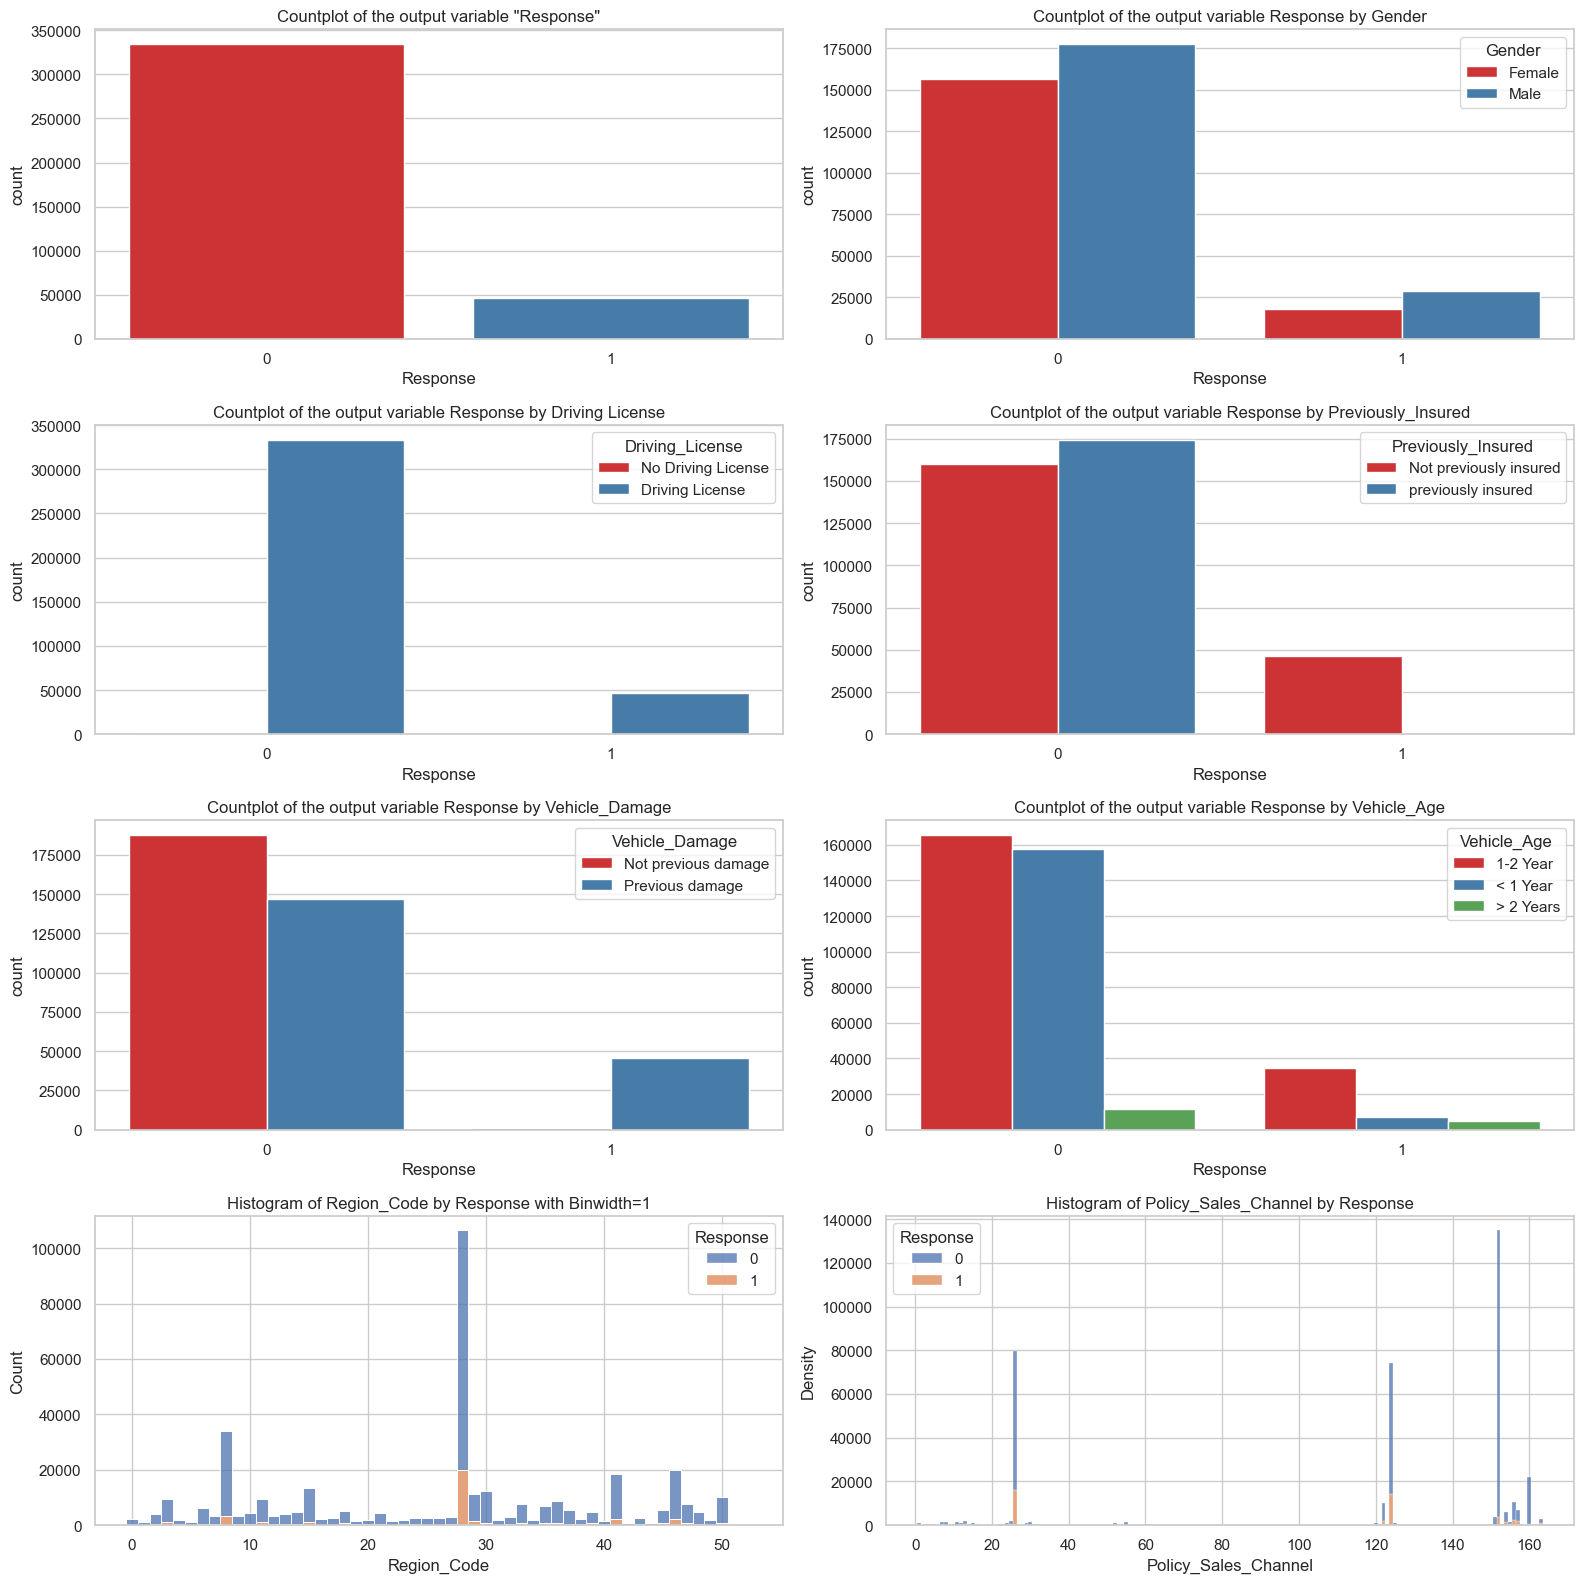

In [16]:
sns.set_theme(style="whitegrid")

perc_y1 = df['Response'].value_counts()[1]/(df['Response'].value_counts()[0] + df['Response'].value_counts()[1])
print(f'The percentage of 1 respondent is: {perc_y1.round(4)*100}%')

gender_cross_tab = pd.crosstab(df['Response'], df['Gender'], margins=True, margins_name='Total') 
print(gender_cross_tab)

Driving_License_cross_tab = pd.crosstab(df['Response'], df['Driving_License'], margins=True, margins_name='Total') 
print(Driving_License_cross_tab)

vehicle_age_cross_tab = pd.crosstab(df['Response'], df['Vehicle_Age'], margins=True, margins_name='Total') 
print(vehicle_age_cross_tab)

fig, axs = plt.subplots(4, 2, figsize=(16, 16))

# Response
sns.countplot(x='Response', data=df, palette='Set1', ax=axs[0, 0]).set(
    title='Countplot of the output variable "Response"')

# Response by Gender
sns.countplot(x='Response', hue='Gender', data=df, palette='Set1', ax=axs[0, 1]).set(
    title='Countplot of the output variable Response by Gender')
axs[0, 1].legend(title='Gender', labels=['Female', 'Male'])

# Response by Driving License
sns.countplot(x='Response', hue='Driving_License', data=df, palette='Set1', ax=axs[1, 0]).set(
    title='Countplot of the output variable Response by Driving License')
axs[1, 0].legend(title='Driving_License', labels=['No Driving License', 'Driving License'])

# Response by Previously_Insured
sns.countplot(x='Response', hue='Previously_Insured', data=df, palette='Set1', ax=axs[1, 1]).set(
    title='Countplot of the output variable Response by Previously_Insured')
axs[1, 1].legend(title='Previously_Insured', labels=['Not previously insured', 'previously insured'])

# Response by Vehicle_Damage
sns.countplot(x='Response', hue='Vehicle_Damage', data=df, palette='Set1', ax=axs[2, 0]).set(
    title='Countplot of the output variable Response by Vehicle_Damage')
axs[2, 0].legend(title='Vehicle_Damage', labels=['Not previous damage', 'Previous damage'])

# Response by Vehicle_Age
sns.countplot(x='Response', hue='Vehicle_Age', data=df, palette='Set1', ax=axs[2, 1]).set(
    title='Countplot of the output variable Response by Vehicle_Age')

# Response by Region
sns.histplot(data=df, x='Region_Code', hue='Response', multiple='stack', binwidth=1, ax=axs[3, 0])
axs[3, 0].set_xlabel('Region_Code')
axs[3, 0].set_ylabel('Count')
axs[3, 0].set_title('Histogram of Region_Code by Response with Binwidth=1')

# Response by Policy_Sales_Channel
sns.histplot(data=df, x='Policy_Sales_Channel', hue='Response', multiple='stack', binwidth=1, ax=axs[3, 1])
axs[3, 1].set_xlabel('Policy_Sales_Channel')
axs[3, 1].set_ylabel('Density')
axs[3, 1].set_title('Histogram of Policy_Sales_Channel by Response')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


Down there are calculated positive response rate for the variables where it is not clear if the differences of Response conditioned to them is due to real different conditional distribution or just to more/less presence of a given category (Gender and Vehicle_Age), and also for Driving_License, to understand why it is shown to be more important than it seems according to Mutual Information (see later).

In [17]:
# Gender
m_tot = df['Gender'].value_counts()[1]
f_tot = df['Gender'].value_counts()[0]
m_yes = gender_cross_tab.loc[1][1]
f_yes = gender_cross_tab.loc[1][0]
print(f"Percentage of male 1-respondent: {round(m_yes/m_tot, 4) * 100}%,\n\
Percentage of female 1-respondent: {round(f_yes/f_tot, 4) * 100}%")
print('\n-----------------------------------------------------')
# Driving_License
yesDriving_tot = df['Gender'].value_counts()[0]
noDriving_tot = df['Gender'].value_counts()[1]
yesDriving_yes = Driving_License_cross_tab.loc[1][1]
noDriving_yes = Driving_License_cross_tab.loc[1][0]
print(f"Percentage of the ones that have a driving license 1-respondent: {round(yesDriving_yes/yesDriving_tot, 4) * 100}%,\n\
Percentage of the ones that don't have a driving license 1-respondent: {round(noDriving_yes/noDriving_tot, 4) * 100}%")
print('\n-----------------------------------------------------')
# Vehicle_Age
one_two_year_tot = df['Vehicle_Age'].value_counts()[0]
less_one_year_tot = df['Vehicle_Age'].value_counts()[1]
more_two_year_tot = df['Vehicle_Age'].value_counts()[2]
one_two_year_yes = vehicle_age_cross_tab.loc[1][0]
less_one_year_yes = vehicle_age_cross_tab.loc[1][1]
more_two_year_yes = vehicle_age_cross_tab.loc[1][2]
print(f"\nPercentage of '1-2 Year' Vehicle_Age 1-respondent\
: {round(one_two_year_yes/one_two_year_tot, 3) * 100}%,\n\
Percentage of '< 1 Year' Vehicle_Age 1-respondent\
: {round(less_one_year_yes/less_one_year_tot, 4) * 100}%,\n\
Percentage of '> 2 Years' Vehicle_Age 1-respondent\
: {round(more_two_year_yes/more_two_year_tot, 4) * 100}%")


Percentage of male 1-respondent: 13.84%,
Percentage of female 1-respondent: 10.39%

-----------------------------------------------------
Percentage of the ones that have a driving license 1-respondent: 26.66%,
Percentage of the ones that don't have a driving license 1-respondent: 0.02%

-----------------------------------------------------

Percentage of '1-2 Year' Vehicle_Age 1-respondent: 17.4%,
Percentage of '< 1 Year' Vehicle_Age 1-respondent: 4.37%,
Percentage of '> 2 Years' Vehicle_Age 1-respondent: 29.37%


As it can be seen, the percentage of 1-respondent is less than 13%, so this is a high imbalanced dataset. It can be important to see if the features provide some meaningful insight about the positiveness or not of the respondents.

Response by Gender:
* There are no substantial differences in the response rates between genders. However, males have have a slightly higher positive response rate compared to females (14% vs 10 %).

Response by Driving License:
* Since almost everyone in the dataset has a driving license, this variable may not provide much discriminatory power in predicting the response. It might not be a useful feature for the model, although specify that one does not have a driving license could enforce a negative prediction (because the positive response rate in the case of no driving license is of just 0.02%).

Response by Previously_Insured:
* Individuals who were not previously insured (Previously_Insured = 0) seem to have a higher likelihood of responding positively to the sales proposal. This variable could have predictive value.

Response by Vehicle_Damage:
* Individuals with past vehicle damage (Vehicle_Damage = 1) seem to respond positively more often to the sales proposal. This variable may be a relevant predictor.

Response by Vehicle_Age:
* Looking, as for gender, not only at the plots but also at the percentages of 1 respondent over the total respondent divided by category, vehicles with an age greater than 2 suggest a good positive response rate (29%), and for the age between 1-2 years the percentage is slightly less (19%). This suggests that greater vehicle age suggests higher 1-response rate.

Response by Region and Policy Sales Channels:
* Certain regions and sales channels have a higher concentration of positive responses. This implies that these categorical variables might contribute to predicting the likelihood of a positive response, but they are a lot and including a single dummy for all of them could bring to an over-complication of the model. So a grouping will be made.

## Graphical analysis II: Response and continuous variables
Analyzing the distribution of the continuous features conditioned on Response

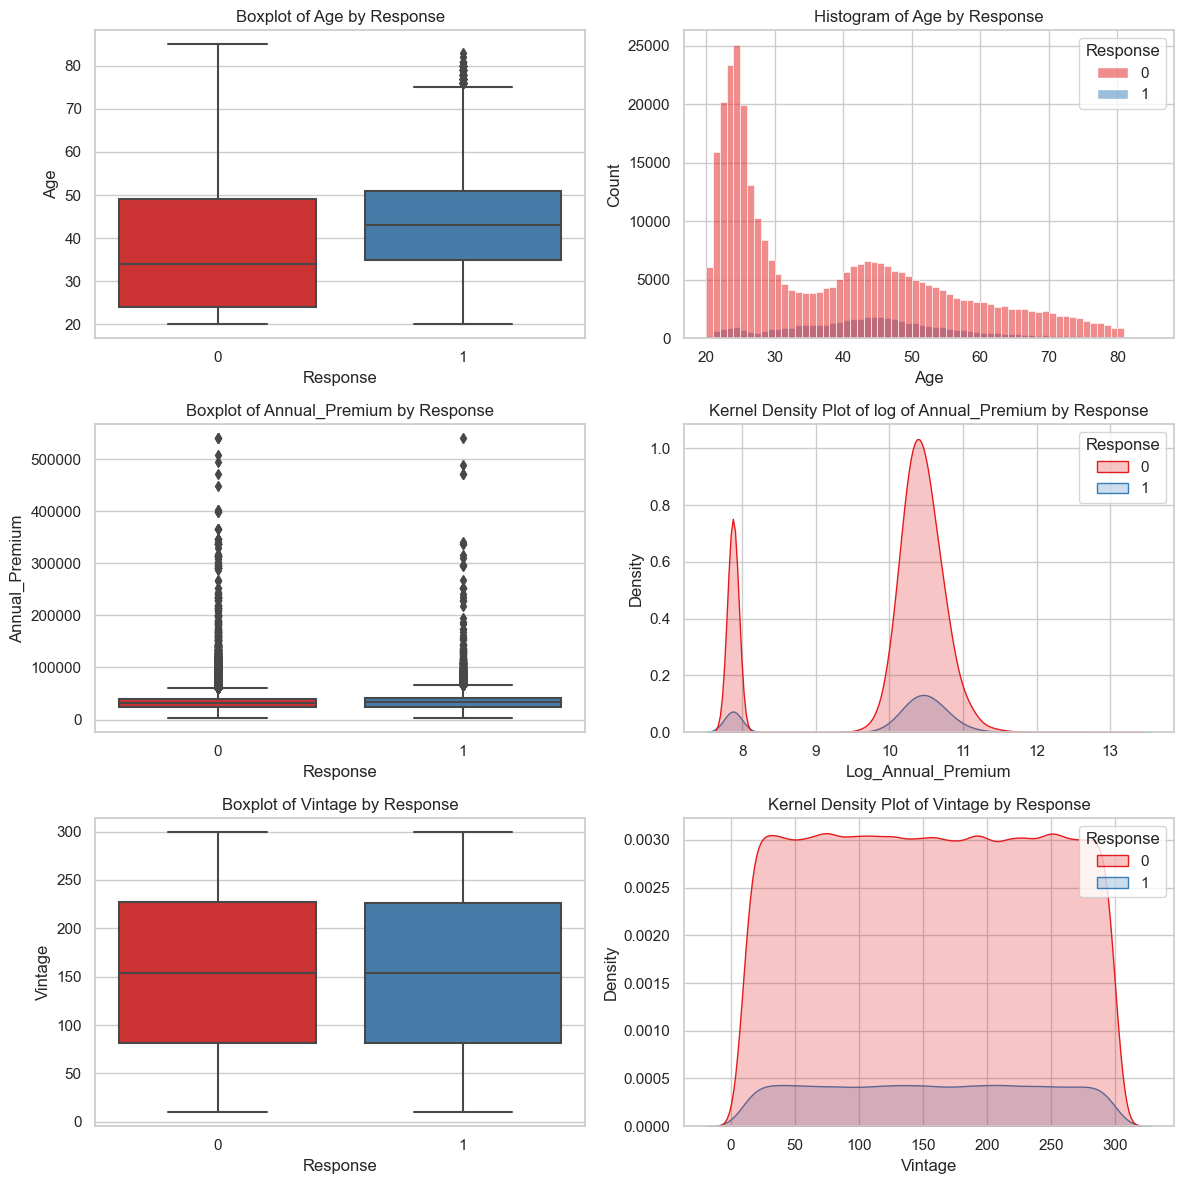

In [18]:
sns.set_theme(style="whitegrid")

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the 2D array of axes to make it easier to iterate
axes = axes.flatten()

# Age by Response
sns.boxplot(x='Response', y='Age', data=df, palette='Set1', ax=axes[0]).set(
    title='Boxplot of Age by Response')

sns.histplot(data=df, x='Age', hue='Response', element='bars', stat='count',
             binwidth=1, palette='Set1', ax=axes[1])
axes[1].set(xlabel='Age', ylabel='Count')
axes[1].set_title('Histogram of Age by Response')

# Annual_Premium by Response
sns.boxplot(x='Response', y='Annual_Premium', data=df, palette='Set1', ax=axes[2]).set(
    title='Boxplot of Annual_Premium by Response')

# Create density plot with log-transformed 'Annual_Premium'
df['Log_Annual_Premium'] = np.log1p(df['Annual_Premium'])
sns.kdeplot(data=df, x='Log_Annual_Premium', hue='Response', fill=True,
            palette='Set1', common_norm=True, ax=axes[3]).set(
    title='Kernel Density Plot of log of Annual_Premium by Response')
df = df.drop('Log_Annual_Premium', axis=1)

# Vintage by Response
sns.boxplot(x='Response', y='Vintage', data=df, palette='Set1', ax=axes[4]).set(
    title='Boxplot of Vintage by Response')

sns.kdeplot(data=df, x='Vintage', hue='Response', fill=True,
            palette='Set1', common_norm=True, ax=axes[5]).set(
    title='Kernel Density Plot of Vintage by Response')

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()

Age by Response:
* The age distribution itself is clearly bimodal. A first peak is in the 20/30 category, while a second, larger peak is at 40/50. The Positive respondents tend to cluster in this second part, so that the age of positive respondents seems to be a slightly good predictor.

Annual_Premium by Response:
* The distribution of annual premiums shows a significant number of outliers, indicating some individuals with exceptionally high premiums. There is high variance, suggesting a wide range of premium values. However, the differences in premium distributions between positive and negative respondents may not be visually evident, implying that annual premium alone might not be a strong predictor of the response. To further understand this, a log-transformation is applied to this variable in order to better appreciate the difference in the conditioned distributions smoothing-off the outliers, and they have the same two peaks, one slightly less than 8 (2980 dollars it is retransformed back) and one between 10 and 11 (2200 and 5990 approximately). This very similar distribution-shape suggets that the annual premium paid is not a good predictor.

Vintage by Response:
* Vintage shows an almost identical shape distribution between positive and negative respondents, and in its range the density is almost uniform! This variable is likeli useless.

## Feature manipulation

Categorical features:
* Vehicle age, given that is represented by three categories and it can be a good predictor, is one hot encoded, and the column with the dummy representing Vehicle_Age_< 1 Year is dropped to avoid collinearity. It is chosen this one just because it is the less informative among the three.

* After having looked for the best grouping (process not reported for brevity), Policy_Sales_Channels and Region_Code have been splitted into three categories respectively: low, medium and high, to encapsulate differences pretty equally balanced among the regions and the channels of sale. To note that there are two channels, 43 and 123, of sales with 100% success with respect to Policy_Sales_levels! (To see it run 'sorted_response_percentage.head(2)'). But this is because there are only two observations where two specific Policy_Sales_levels have been used, so this is not accounted for in order to not overfit) (To see it run ' pd.concat([df[df['Policy_Sales_Channel'] == 43],df[df['Policy_Sales_Channel'] == 123]]) ' ). For those two, when the pandas method get_dummies() is used, the ' drop_first = True ' is used to avoid the dummy variable trap (in this case so they are not manually removed like for Vehicle_Age, because the first dummy in those two cases were the least informative). 

* The other dummies that are only 0/1 are just kept, changing the string values in 0/1 values. To note that when the pandas method get_dummies() is used, the drop_first = True is used to avoid the dummy variable trap.

In [27]:
df = pd.read_csv(DIR + 'insurance_cross_sell.csv')
df = df.drop('id', axis = 1)
# Vehicle_Age
dummy_df = pd.get_dummies(df['Vehicle_Age'], prefix='Vehicle_Age').astype(int)
df = df.drop('Vehicle_Age', axis = 1)
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('Vehicle_Age_< 1 Year', axis = 1)

# Region_Code
# Calculate response percentage by region
response_percentage_by_region = df.groupby('Region_Code')['Response'].mean() * 100
sorted_response_percentage = response_percentage_by_region.sort_values(ascending=False)
quantiles = sorted_response_percentage.quantile([0.33, 0.67])
quantiles_list = [0] + quantiles.tolist() + [100]
bin_labels = ['Low', 'Medium', 'High']
region_levels = pd.cut(sorted_response_percentage, bins=quantiles_list, 
       labels=bin_labels, include_lowest=True)
df['Region_Code_levels'] = df['Region_Code'].map(region_levels)
#print(f"NA LEVELS {df['Region_Code_levels'].isna().sum()}")
region_dummies = pd.get_dummies(df['Region_Code_levels'], prefix='Region_Level', 
                                drop_first=True).astype(int)
# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, region_dummies], axis=1)
#df = df.drop('Region_Code', axis = 1)

# Policy_Sales_Channel
# Calculate response percentage by Policy_Sales_Channel
response_percentage_by_Policy_Sales_Channel = df.groupby('Policy_Sales_Channel')['Response'].mean() * 100
sorted_response_percentage = response_percentage_by_Policy_Sales_Channel.sort_values(ascending=False)
quantiles = sorted_response_percentage.quantile([0.33, 0.67])
quantiles_list = [0] + quantiles.tolist() + [100]
bin_labels = ['Low', 'Medium', 'High']
policy_levels = pd.cut(sorted_response_percentage, bins=quantiles_list, 
       labels=bin_labels, include_lowest=True)
df['Policy_Sales_levels'] = df['Policy_Sales_Channel'].map(policy_levels)
#print(f"NA LEVELS {df['Policy_Sales_levels'].isna().sum()}")
policy_dummies = pd.get_dummies(df['Policy_Sales_levels'], prefix='Policy_Sales_Channels', 
                                drop_first=True).astype(int)
df = pd.concat([df, policy_dummies], axis=1)
#df = df.drop('Policy_Sales_Channel',axis = 1)

# Gender and Vehicle_Damage
df['Gender'] = df['Gender'].map({'Male':1, 'Female':0})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes':1, 'No':0})
df.info()
print(df.isna().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   Gender                        381109 non-null  int64   
 1   Age                           381109 non-null  int64   
 2   Driving_License               381109 non-null  int64   
 3   Region_Code                   381109 non-null  float64 
 4   Previously_Insured            381109 non-null  int64   
 5   Vehicle_Damage                381109 non-null  int64   
 6   Annual_Premium                381109 non-null  float64 
 7   Policy_Sales_Channel          381109 non-null  float64 
 8   Vintage                       381109 non-null  int64   
 9   Response                      381109 non-null  int64   
 10  Vehicle_Age_1-2 Year          381109 non-null  int32   
 11  Vehicle_Age_> 2 Years         381109 non-null  int32   
 12  Region_Code_levels            

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1-2 Year,Vehicle_Age_> 2 Years,Region_Code_levels,Region_Level_Medium,Region_Level_High,Policy_Sales_levels,Policy_Sales_Channels_Medium,Policy_Sales_Channels_High
0,1,44,1,28.0,0,1,40454.0,26.0,217,1,0,1,High,0,1,High,0,1
1,1,76,1,3.0,0,0,33536.0,26.0,183,0,1,0,High,0,1,High,0,1
2,1,47,1,28.0,0,1,38294.0,26.0,27,1,0,1,High,0,1,High,0,1
3,1,21,1,11.0,1,0,28619.0,152.0,203,0,0,0,Medium,1,0,Low,0,0
4,0,29,1,41.0,1,0,27496.0,152.0,39,0,0,0,High,0,1,Low,0,0


In [20]:
cross_tab = pd.crosstab(df['Response'], df['Policy_Sales_levels'], margins=True, margins_name='Total') 
print(cross_tab)
cross_tab = pd.crosstab(df['Response'], df['Region_Code_levels'], margins=True, margins_name='Total') 
print(f'--------------------------------------------------------------\
\n{cross_tab}')

# Policy_Sales_levels
policy_sales_tot = df['Policy_Sales_levels'].value_counts()
policy_sales_yes = pd.crosstab(df['Response'], df['Policy_Sales_levels']).loc[1]
print(f'\n--------------------------------------------------------------')
for level in policy_sales_tot.index:
    total_count = policy_sales_tot[level]
    yes_count = policy_sales_yes[level]
    percentage = (yes_count / total_count) * 100
    print(f"Percentage of '{level}' Policy_Sales_levels 1-respondent: {round(percentage, 3)}%")

print(f'\n--------------------------------------------------------------')
# Region_Code_levels
region_code_tot = df['Region_Code_levels'].value_counts()
region_code_yes = pd.crosstab(df['Response'], df['Region_Code_levels']).loc[1]
for level in region_code_tot.index:
    total_count = region_code_tot[level]
    yes_count = region_code_yes[level] 
    percentage = (yes_count / total_count) * 100
    print(f"Percentage of '{level}' Region_Code_levels 1-respondent: {round(percentage, 3)}%")


Policy_Sales_levels     Low  Medium    High   Total
Response                                           
0                    158205   15155  161039  334399
1                      4538    1710   40462   46710
Total                162743   16865  201501  381109
--------------------------------------------------------------
Region_Code_levels    Low  Medium    High   Total
Response                                         
0                   73470  110608  150321  334399
1                    5472   11851   29387   46710
Total               78942  122459  179708  381109

--------------------------------------------------------------
Percentage of 'High' Policy_Sales_levels 1-respondent: 20.08%
Percentage of 'Low' Policy_Sales_levels 1-respondent: 2.788%
Percentage of 'Medium' Policy_Sales_levels 1-respondent: 10.139%

--------------------------------------------------------------
Percentage of 'High' Region_Code_levels 1-respondent: 16.353%
Percentage of 'Medium' Region_Code_levels 1-respo

## Feature importance & selection with the manipulated dataset

Different criteria will be applied. 
* First a simple correlation matrix for the quantitative variables will be inspected, to see if there are issues of multicollinearity.
* Secondly, the chi-square association test will be used specifically for the great number of dummy variables.
* Lastly, the mutual information score will be used: it will be the more relevant because it can be used for both quantitative and dummy variables (it must be specified which variable is of which type, and this will be done via a boolean mask) to see how much they associate with the response. Noting that this measure is invariant to the unit of measure used, so scaling in this step is not necessary.

### Creation of X, that contains all the features, and y, with the Response

In [28]:
to_drop = ['Policy_Sales_levels','Region_Code_levels',
           'Policy_Sales_Channel','Region_Code', 'Response']
X = df.drop(columns=to_drop)
y = df['Response']
quantitative_vars = ['Age', 'Annual_Premium', 'Vintage']
dummy_vars = [col for col in X.columns if col not in quantitative_vars]
# Create a DataFrame for quantitative variables only
X_quantitative = X[quantitative_vars]
# Create a DataFrame for dummy variables only
X_dummy = X[dummy_vars]

### Simple correlation

Here it is shown a correlation plot with all the quantitative variables (and the target, even if categorical, just for curiosity, but it is surely not indicative in this case).

<Axes: >

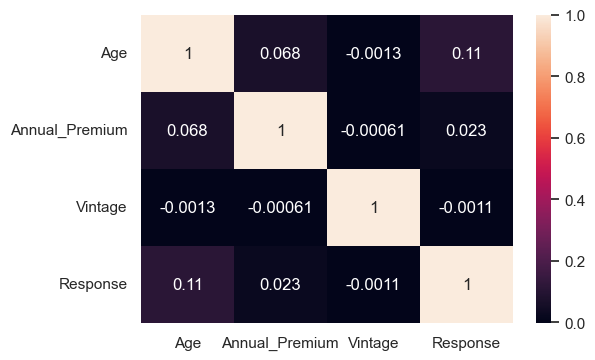

In [22]:
plt.figure(figsize = (6,4))
sns.heatmap(df[quantitative_vars + ['Response']].corr(), annot = True)

### Feature importance by Cramer's V (normalized chi-square)
Specific for the categorical variables

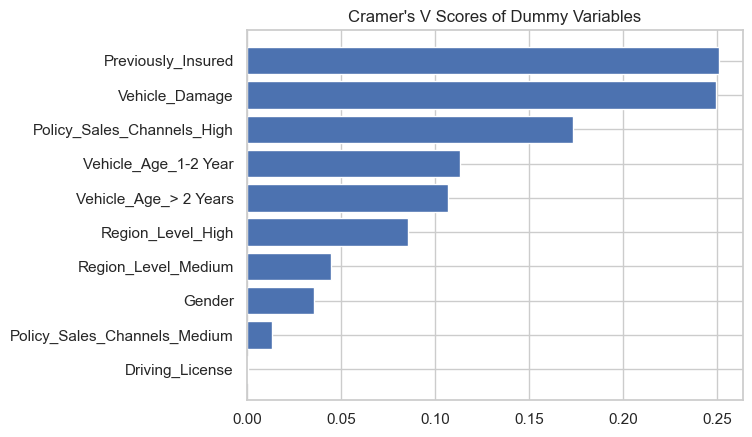

In [23]:
X_dummy_fs, fs = select_features(X_dummy, y, chi2)
chi2_scores = fs.scores_
N = X_dummy.shape[0]  # total number of samples
C = X_dummy.shape[1]  # number of features
R = 2  # assuming binary classification (Response = 0 or 1)
cramers_v_scores = cramers_v(chi2_scores, N, C, R)
cramers_v_scores = pd.Series(cramers_v_scores, index = dummy_vars)
plot_scores(cramers_v_scores, title = "Cramer's V Scores of Dummy Variables")

### Feature importance by Mutual Information
For both categorical and quantitative variables

In [29]:
X['log_Annual_Premium'] = np.log(X['Annual_Premium'])

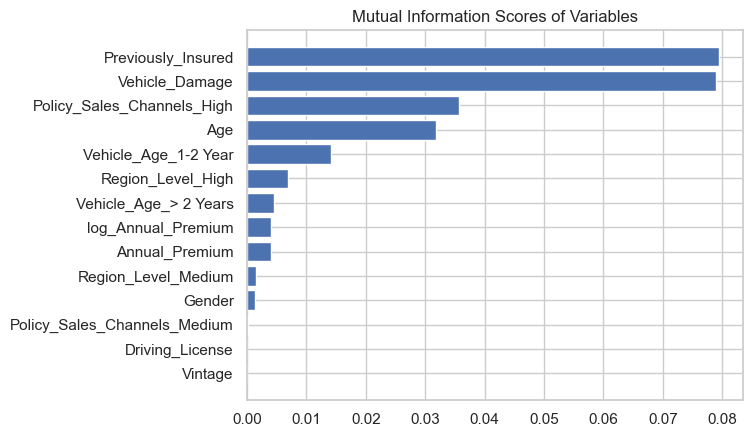

In [30]:
q_cols = ['Age', 'Annual_Premium', 'Vintage','log_Annual_Premium']
# changing into float
X[q_cols] = X[q_cols].astype(float)
#changing into int
X[[x for x in X.columns if x not in q_cols]] = X[[x for x in X.columns if x not in q_cols]].astype(int)
#getting dummies for the mask, necessary for the function 
discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)

plot_scores(mi_scores, title = 'Mutual Information Scores of Variables')


All those visualization help to understand which variables can be kept and which can be thrown away.

According to the V index and the Mutual Information score, dummies like Driving_License and Policy_Sales_Channels_Medium are useless, those will be dropped. Gender and Region_Level_Medium are very little informative, but for now they will be kept. 

For the quantitative variables (so looking now only at the Mutual Information Score) the logarithmic transformation seems to be a little more informative (but anything incredible) with respect to the not transformed version. Vintage is not informative at all, as expected. So Vintage and Annual_Premium (but not the logarithmic version) will be dropped.

The point in doing so is that for sure a raw and wild grid search for all variables, all possible combinations etc could be done and would maybe be better for prediction-driven tasks, but the process in doing so can be very slow. Instead, a reasoned model could be a valid alternative. Anyway, at first also a model with all the variables will be tested just for fun and for checking if there are relevant differences in a complete-feature model and a model where some features have been dropped.

## Models I: no feature transformations

An X_all, with all the features (not Annual_premium because the log version is kept) with a new X are created, and with the last one the variables not so informative are dropped, as written before.

The procedure followed will be to split in train and test set the both, and with the train set performing a 5-fold Cross-Validation that will record different metrics to evaluate different models. To assess the better models not only accuracy or AUC of the ROC curve are used, because in case of a highly imbalanced data those types of measures don't capture very well the capacity to find the positive respondents. Instead, Recall and Precision will be considered much more (and so also f1 score), and even the AUC of the Precision-Recall Curve, that capture the trade-off between Recall and Precision and is maybe a better metrics with respect to the AUC of the ROC.

In [31]:
X_all = X.copy()
X_all = X_all.drop('Annual_Premium', axis = 1)
to_drop = ['Driving_License','Vintage', 'Annual_Premium', 'Policy_Sales_Channels_Medium']
X = X.drop(columns=to_drop, axis = 1)
X.head()

,Gender,Age,Previously_Insured,Vehicle_Damage,Vehicle_Age_1-2 Year,Vehicle_Age_> 2 Years,Region_Level_Medium,Region_Level_High,Policy_Sales_Channels_High,log_Annual_Premium
0,1,44.0,0,1,0,1,0,1,1,10.607921
1,1,76.0,0,0,1,0,0,1,1,10.420375
2,1,47.0,0,1,0,1,0,1,1,10.553049
3,1,21.0,1,0,0,0,1,0,0,10.261826
4,0,29.0,1,0,0,0,0,1,0,10.221796


In [32]:
print(f'X_all shape: {X_all.shape}, X shape: {X.shape}, y shape: {y.shape}')

X_all shape: (381109, 13), X shape: (381109, 10), y shape: (381109,)


### splitting and 5-fold CV

Note: After lots of different tries, only the Logistic Regressions with l2 penalties will be performed: this is due to the fact that behind this report the l1 have been performed and the results are almost the same, so to re-run faster the code and to not write too much models, only the l2 regularization will be kept (and also a model without regularization). Another reason is the fact that a first feature selection have already been performed, dropping the variables not relevant by a first analysis (first part of the report) so that an l1 regularization that tends to eliminate the features and not smoothing their coefficients down seems to be a bit unnecessary and over-killing in this precise context and for those logistic models. 

In [289]:
X_train, X_test, y_train, y_test = train_test_splitting(X, y)
X_all_train, X_all_test, y_train, y_test = train_test_splitting(X_all, y)

models = [
    LogisticRegression(penalty=None, max_iter=500),
    LogisticRegression(penalty='l2', C=10, max_iter=500),
    LogisticRegression(penalty='l2', C=1, max_iter=500),
    LogisticRegression(penalty='l2', C=0.1, max_iter=500),
    LogisticRegression(penalty='l2', C=0.01, max_iter=500),
    LogisticRegression(penalty='l2', C=0.001, max_iter=500),
    LogisticRegression(penalty='l2', C=0.0001, max_iter=500),
    LogisticRegression(penalty='l2', C=0.00001, max_iter=500)
]

mod_names = ['lr', 'lr_l2_10', 'lr_l2_1', 'lr_l2_.1', 
                  'lr_l2_.01', 'lr_l2_.001', 'lr_l2_.0001', 'lr_l2_.00001']

roc_auc_scores = {}
precision_recall_auc_scores = {}
roc_auc_scores_all = {}
precision_recall_auc_scores_all = {}
cv_res = {}
cv_res_all = {}

for i, model in enumerate(models):
    (cv_res[mod_names[i]],
    precision_recall_auc_scores[mod_names[i]],
    roc_auc_scores[mod_names[i]]) = cross_validator_with_thresholds(model, X_train, y_train, n_folds=5, 
                                    oversampling=True, print_cv=True, print_shape=True)
    (cv_res_all[mod_names[i]],
    precision_recall_auc_scores_all[mod_names[i]],
    roc_auc_scores_all[mod_names[i]]) = cross_validator_with_thresholds(model, X_all_train, 
                                                                       y_train, n_folds=5, 
                                    oversampling=True, print_cv=True, print_shape=True)
    print(f'\nCross-validated the {i+1}th model of the list')
    print('------------------------------------------------------')

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 13), X resampled shape: (428032, 13),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 13), X resampled shape: (428032, 13),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)

Cross-validated the 1th model of the list
------------------------------------------------------
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 13), X resampled shape: (428032, 13),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Respo

### Graphical analysis of differences in AUC (Area Under the Curve)
Considering the ROC curve and the Precision-Recall Curve

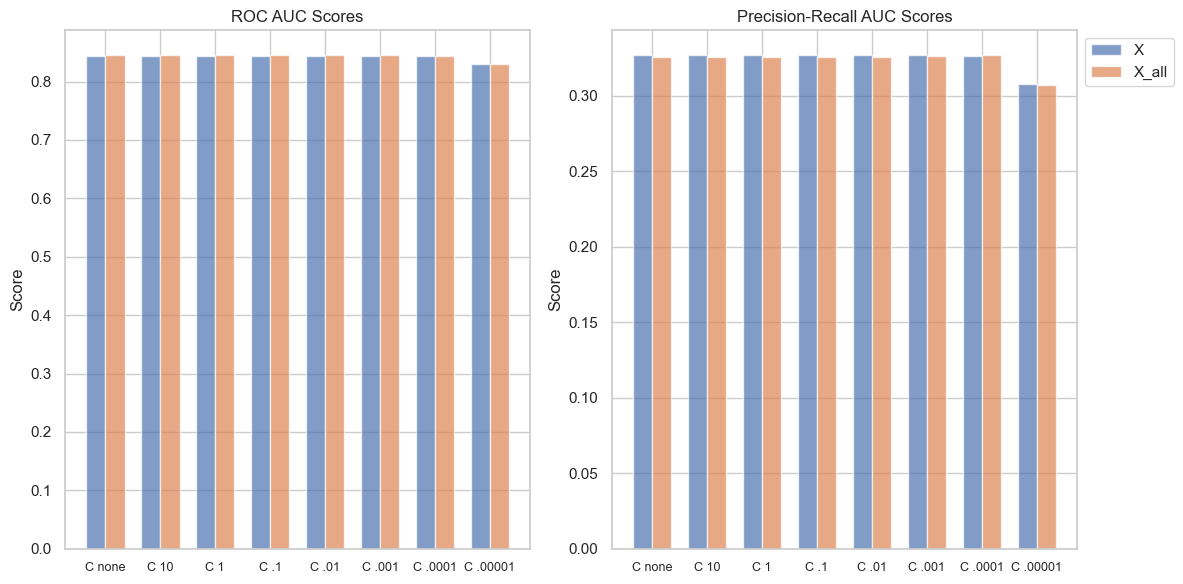

In [34]:
# Data
x_values = np.arange(len(models))
bar_width = 0.35
C_penalties = ['C none', 'C 10', 'C 1', 'C .1', 
                  'C .01', 'C .001', 'C .0001', 'C .00001']
# Plotting for roc_auc_scores and precision_recall_auc_scores
plt.figure(figsize=(12, 6))

# ROC AUC Scores
plt.subplot(1, 2, 1)
plt.bar(x_values, list(roc_auc_scores.values()), width=bar_width, align='center', alpha=0.7, label='X')
plt.bar(x_values + bar_width, list(roc_auc_scores_all.values()), width=bar_width, align='center', alpha=0.7, label='X_all')
plt.xticks(x_values + bar_width / 2, C_penalties, fontsize=9)
plt.title('ROC AUC Scores')
plt.ylabel('Score')

# Precision-Recall AUC Scores
plt.subplot(1, 2, 2)
plt.bar(x_values, list(precision_recall_auc_scores.values()), width=bar_width, align='center', alpha=0.7, label='X')
plt.bar(x_values + bar_width, list(precision_recall_auc_scores_all.values()), width=bar_width, align='center', alpha=0.7, label='X_all')
plt.xticks(x_values + bar_width / 2, C_penalties, fontsize=9)
plt.title('Precision-Recall AUC Scores')
plt.ylabel('Score')

# Adjust legend position for the second plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

The metrics are almost identical! For the ROC case, the X_all shows a very little bit higher values, while for the Precision-Recall case it is the X with less features that performs better (and this is more important, because in the case of high imbalanced data, Precision and Recall are much more informative about the goodness of the model).
Excluding the most penalized one (C = 0.00001) the metrics are very similar.

In [35]:
pr_scores_df = pd.DataFrame(list(precision_recall_auc_scores.items()), columns=['Model', 'Precision_Recall_AUC_Score'])
pr_scores_df = pr_scores_df.sort_values(by='Precision_Recall_AUC_Score', ascending=False)
pr_scores_df

,Model,Precision_Recall_AUC_Score
5,lr_l2_.001,0.326789
0,lr,0.326778
3,lr_l2_.1,0.326748
2,lr_l2_1,0.326670
1,lr_l2_10,0.326666
4,lr_l2_.01,0.326660
6,lr_l2_.0001,0.325958
7,lr_l2_.00001,0.307637


### Graphical analysis of ROC and Precision-Recall curves

Preliminary steps to calculate the predicted probabilities before plotting. 

Only three out of the total models are used for clarity, given they are almost the same. In the for loop the three models are fitted for X and X_all, the predicted probbilities calculated and everything put inside the custom class ThresholdEvaluatorLogReg, useful for getting areas and scores for different thresholds (it is used also implicitely in the function for the k-fold CV used before), for the different models.

Note that here the predicted probabilities are calculated not with the k-fold CV but directly on the X_test constructed before. Using resampling or class_weight='balanced' gives the same results (this has been tested but it is not reported here), so, instead of resampling again, like in the k-fold cv, the argument class_weight='Balanced' in the LogisticRegression class will be used when fitting the model.


In [36]:
evaluators = {}
evaluators_all = {}
models = [LogisticRegression(penalty=None, max_iter=500, class_weight='balanced'),
        LogisticRegression(penalty='l2', C=0.001, max_iter=500, class_weight='balanced'),
        LogisticRegression(penalty='l2', C=0.00001, max_iter=500, class_weight='balanced')]
mod_names = ['lr', 'lr_l2_.001','lr_l2_.00001']
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    
    model.fit(X_all_train, y_train)
    y_pred_proba_all = model.predict_proba(X_all_test)
    print('------------------------------------------------------')
    print(f'\nfitted the {i+1}th model of the list')

    evaluators[mod_names[i]] = ThresholdEvaluatorLogReg(y_test, y_pred_proba)
    evaluators_all[mod_names[i]] = ThresholdEvaluatorLogReg(y_test, y_pred_proba_all)

------------------------------------------------------

fitted the 1th model of the list
------------------------------------------------------

fitted the 2th model of the list
------------------------------------------------------

fitted the 3th model of the list


#### ROC and Precision-Recall

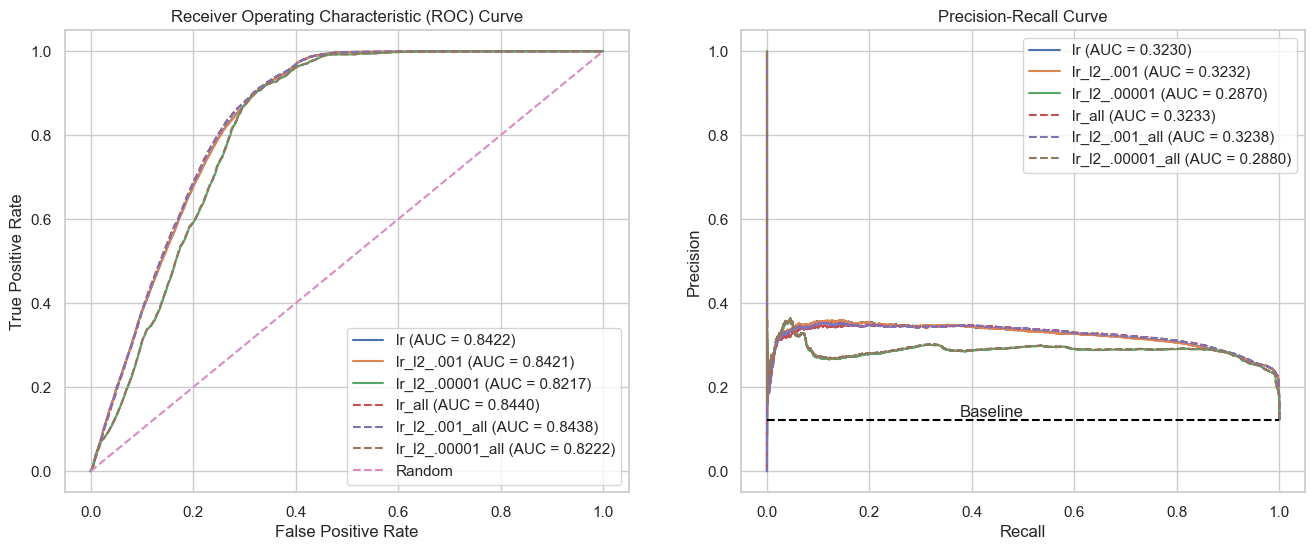

In [37]:
# Plot ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot ROC curves for evaluators
for model_name in mod_names:
    fpr, tpr, _ = roc_curve(y_test, evaluators[model_name].get_pred_probs())
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

# Plot ROC curves for evaluators_all
for model_name in mod_names:
    fpr, tpr, _ = roc_curve(y_test, evaluators_all[model_name].get_pred_probs())
    roc_auc_all = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{model_name}_all (AUC = {roc_auc_all:.4f})', linestyle='--')

ax1.plot([0, 1], [0, 1], linestyle='--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')

# Plot Precision-Recall curves for evaluators
for model_name in mod_names:
    precision, recall, _ = precision_recall_curve(y_test, evaluators[model_name].get_pred_probs())
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.4f})')

# Plot Precision-Recall curves for evaluators_all
for model_name in mod_names:
    precision, recall, _ = precision_recall_curve(y_test, evaluators_all[model_name].get_pred_probs())
    pr_auc_all = auc(recall, precision)
    ax2.plot(recall, precision, label=f'{model_name}_all (AUC = {pr_auc_all:.4f})', linestyle='--')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='upper right')
ax2.set_title('Precision-Recall Curve')
baseline = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [baseline, baseline], linestyle='--', color='black') 
ax2.text(0.5, baseline, 'Baseline', verticalalignment='bottom', horizontalalignment='right')

plt.show()

Again, between X and X_all there seems to be almost no differences. It is clear that the models are better than random predictors (ROC) and baseline predictor (Precision equal to the rate of positive respondents in the dataset), but the performances really don't change.

### Graphical analysis of how metrics change according to the thresholds

Now is performed a graphical representation of how the different thresholds influences the metrics.
All the models are represented, just for X (not for X_all because the metrics are almost the same).

Specifically, accuracy, f1 (the two more general) and Precision and Recall (the two of most interest for this project, for which f1 is the harmonic mean) are taken into account. They are plotted on the y-axis, while on the x-axis are represented the thresholds.

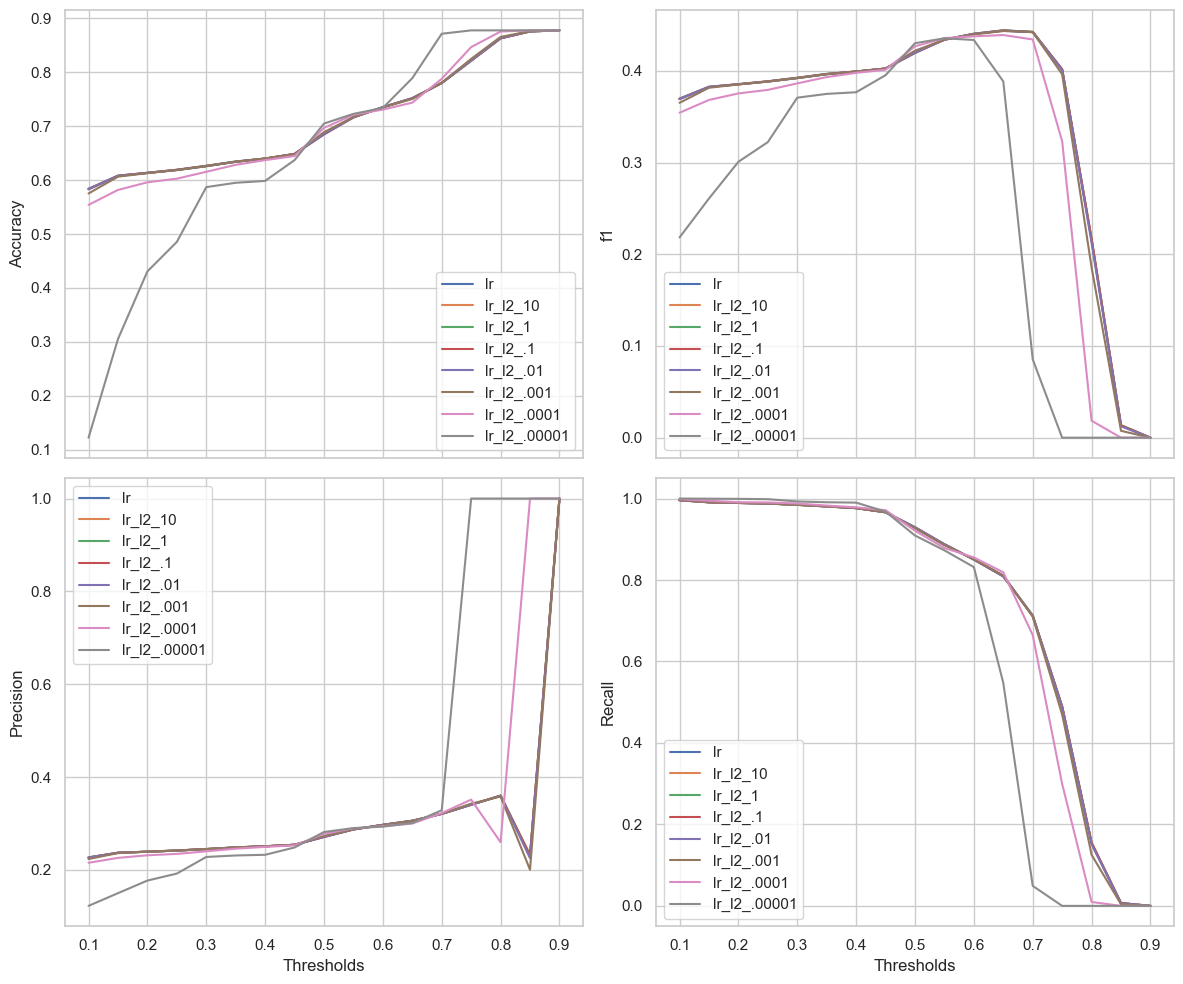

In [38]:
# Define the threshold values
thresholds = cv_res['lr'].index.to_list()

# Define the models
models = list(cv_res.keys())

# Define metrics
metrics = cv_res['lr'].columns.to_list()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True)

# Plot accuracy and f1 on the first row
for model in models:
    axes[0, 0].plot(thresholds, cv_res[model]['Accuracy on Test'].values, label=model)
    axes[0, 1].plot(thresholds, cv_res[model]['f1 on Test'].values, label=model)

axes[0, 0].set_ylabel('Accuracy')
axes[0, 1].set_ylabel('f1')
axes[0, 0].legend(loc='best')
axes[0, 1].legend(loc='best')

# Plot precision and recall on the second row
for model in models:
    axes[1, 0].plot(thresholds, cv_res[model]['Precision on Test'].values, label=model)
    axes[1, 1].plot(thresholds, cv_res[model]['Recall on Test'].values, label=model)

axes[1, 0].set_xlabel('Thresholds')
axes[1, 1].set_xlabel('Thresholds')
axes[1, 0].set_ylabel('Precision')
axes[1, 1].set_ylabel('Recall')
axes[1, 0].legend(loc='best')
axes[1, 1].legend(loc='best')

plt.tight_layout()
plt.show()


At the threshold of 0.5 the models behave in an exact way. The f1 (top-right) peaks at 0.6/0.7, while accuracy (top-left) is almost of 90% for all models but after the 0.8 threshold: this is clearly due to the fact that with such a high threshold few observations are predicted positve, and a lot of real observations indeed are not positive, so predicting negative is with high probabiility the true choice; this is why accuracy is maybe not the best indicator in this case.

The Recall (out of the total positive, what percentage are predicted positive), at the bottom-right, falls down around 0.6, while Precision (out of all the positive predicted, what percentage is truly positive), at the bottom left, remains pretty low until, after 0.7 for some models, 0.8/0.9 for others, spikes up. 

To note the most regularized model how extreme is in the increasing of Precision and falling of Recall. And it is also the most variable in accuracy and f1, starting to be the lowest and ending to be the highest: it is the most sensitive to the threshold.

### Glimpse at the coefficients

Quick building of a dataframe with the coefficients from the penalized model with C = 0.001, that seems the best compromise overall according to the Precision-Recall curve, to understand which variables keep the higher coefficients for the log-odds of the Response.

                              Coefficients  Coefficients_all
Previously_Insured               -1.915820         -1.904837
Age                              -0.367548         -0.377302
Region_Level_Medium               0.034313          0.026705
Gender                            0.039332          0.037375
log_Annual_Premium                0.053764          0.055236
Region_Level_High                 0.144914          0.133925
Vehicle_Age_> 2 Years             0.150446          0.108373
Vehicle_Age_1-2 Year              0.286597          0.178713
Policy_Sales_Channels_High        0.470312          0.639728
Vehicle_Damage                    0.986309          0.976972
Vintage                                NaN          0.000515
Driving_License                        NaN          0.054253
Policy_Sales_Channels_Medium           NaN          0.175597


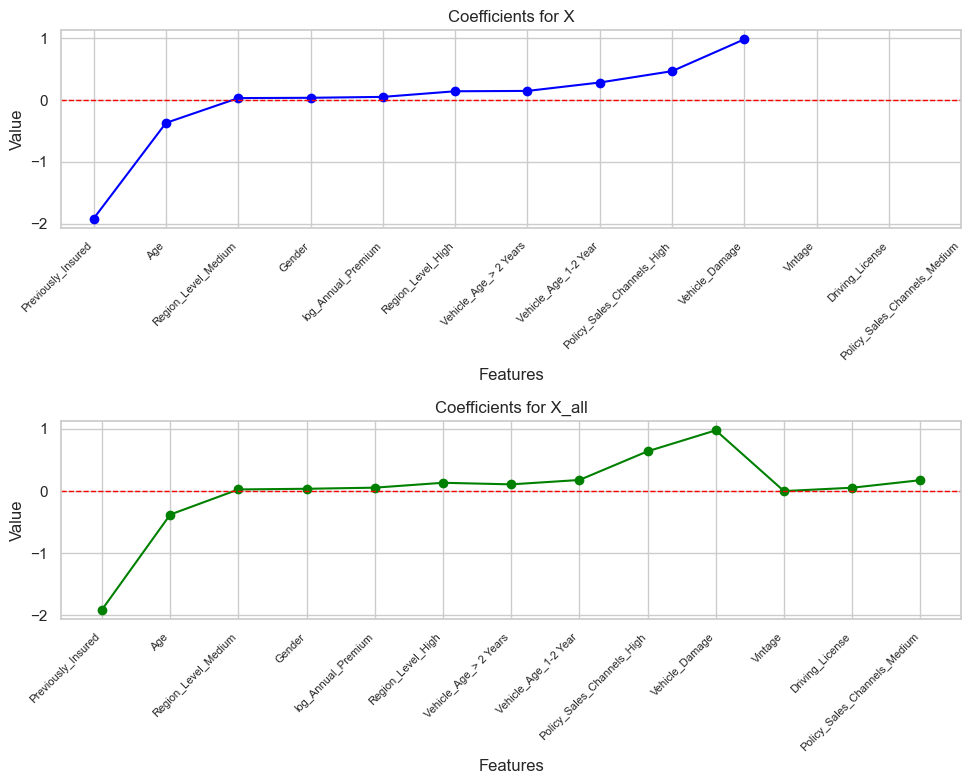

In [40]:
# For lr_all
lr_l2_01_all = LogisticRegression(penalty='l2', C=0.1, max_iter=500)
lr_for_coeff_all = lr_l2_01_all.fit(X_all_train, y_train)
coefficients_all = lr_for_coeff_all.coef_

# Create DataFrame for coefficients for lr_all
coefficients_df_all = pd.DataFrame(data=coefficients_all, columns=X_all_train.columns.to_list())
coefficients_df_all = coefficients_df_all.transpose()
coefficients_df_all.columns = ['Coefficients_all']
coefficients_df_all = coefficients_df_all.sort_values(by='Coefficients_all')

# For lr
lr_l2_01 = LogisticRegression(penalty='l2', C=0.1, max_iter=500)
lr_for_coeff = lr_l2_01.fit(X_train, y_train)
coefficients = lr_for_coeff.coef_

# Create DataFrame for coefficients for lr
coefficients_df = pd.DataFrame(data=coefficients, columns=X.columns.to_list())
coefficients_df = coefficients_df.transpose()
coefficients_df.columns = ['Coefficients']
coefficients_df = coefficients_df.sort_values(by='Coefficients')

# Merge DataFrames
coefficients_combined_df = pd.concat([coefficients_df, coefficients_df_all], axis=1)

# Display the combined DataFrame
print(coefficients_combined_df)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot for 'Coefficients'
coefficients_combined_df['Coefficients'].plot(ax=axes[0], marker='o', linestyle='-', color='blue')
axes[0].set_title('Coefficients for X')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Value')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1) 
axes[0].set_xticks(range(len(coefficients_combined_df.index))) 
axes[0].set_xticklabels(coefficients_combined_df.index, rotation=45, ha='right', 
                        fontsize=8)
# Plot for 'Coefficients_all'
coefficients_combined_df['Coefficients_all'].plot(ax=axes[1], marker='o', linestyle='-', color='green')
axes[1].set_title('Coefficients for X_all')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Value')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1) 
axes[1].set_xticks(range(len(coefficients_combined_df.index))) 
axes[1].set_xticklabels(coefficients_combined_df.index, rotation=45, ha='right', 
                        fontsize=8)
plt.tight_layout()
plt.show()

Seeing the two plots of the coefficients, clearly the two X's lead to the same coefficients for the common variables, and when X_all is used, the more variables it has are basically zero, except for Policy_Sales_Medium. The two dummies Region_Level_Medium and Gender, that were sligthly above zero according to the Vramer's V and the Mutual Information, show off a coefficient of almost zero, along with the log of Annual_Premium. 

So a logistic model with those variables is perhaps not so good in predicting the response. 

Maybe including powers and interactions improve the situation

Very big disclaimer: here the confidence interval are missing! But this is not a statistic project, so the focus is not on inference on the parameters, and this plot is intended just to have an idea of the estimation and of the difference between using the "regularized" dataset or the complete dataset.

## Models II: Polynomial, Interactions and both

To try to improve the fit, now are built three models:
* with polynomial features and interactions only between quantitative variables and the dummies with no interaction
* with interactions including all the dummies, but no power transformations
* with both features and interactions

Some preliminary feature selection will be done as before according to Mutual Information Score

### Poly I
Polynomial up to the third degree are built, with no interaction with the dummies but only between quantitative variables. 

To note that Vintage is reincluded, because maybe even if alone it does not say nothing about the response, some interaction can provide information.

Moreover, Annual_Premium is log-transformed to avoid big outliers to explode with the power transformation with possible consequences on the estimation, and to be consistent also with the previous choice to use the log transformation.

#### Re-inizializing the X dataset

In [41]:
#quantitative_vars.append('Vintage')
to_drop = ['Policy_Sales_levels','Region_Code_levels',
           'Policy_Sales_Channel','Region_Code', 'Response']
X = df.drop(columns=to_drop)
X['log_Annual_Premium'] = np.log(X['Annual_Premium'])
X = X.drop('Annual_Premium', axis = 1)
quantitative_vars = ['Age', 'log_Annual_Premium', 'Vintage']
dummy_vars = [col for col in X.columns if col not in quantitative_vars]
# Create a DataFrame for quantitative variables only
X_quantitative = X[quantitative_vars]
# Create a DataFrame for dummy variables only
X_dummy = X[dummy_vars]
# making float quantitative vars and int dummies for later
X[quantitative_vars] = X[quantitative_vars].astype(float)
X[dummy_vars] = X[dummy_vars].astype(int)
print(X.dtypes)
X.head()

Gender                            int32
Age                             float64
Driving_License                   int32
Previously_Insured                int32
Vehicle_Damage                    int32
Vintage                         float64
Vehicle_Age_1-2 Year              int32
Vehicle_Age_> 2 Years             int32
Region_Level_Medium               int32
Region_Level_High                 int32
Policy_Sales_Channels_Medium      int32
Policy_Sales_Channels_High        int32
log_Annual_Premium              float64
dtype: object


,Gender,Age,Driving_License,Previously_Insured,Vehicle_Damage,Vintage,Vehicle_Age_1-2 Year,Vehicle_Age_> 2 Years,Region_Level_Medium,Region_Level_High,Policy_Sales_Channels_Medium,Policy_Sales_Channels_High,log_Annual_Premium
0,1,44.0,1,0,1,217.0,0,1,0,1,0,1,10.607921
1,1,76.0,1,0,0,183.0,1,0,0,1,0,1,10.420375
2,1,47.0,1,0,1,27.0,0,1,0,1,0,1,10.553049
3,1,21.0,1,1,0,203.0,0,0,1,0,0,0,10.261826
4,0,29.0,1,1,0,39.0,0,0,0,1,0,0,10.221796


#### Construction of the polynomial dataset 
with interactions between only the quantitative variables

In [42]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_quantitative_poly = poly.fit_transform(X_quantitative)
log_quantitative_vars = X_quantitative.columns.to_list()
X_poly_quant = pd.concat([pd.DataFrame(X_quantitative_poly, 
                    columns=poly.get_feature_names_out(log_quantitative_vars)), 
                    X_dummy], axis=1)
# X_poly_quant = X_poly_quant.drop(['Vintage','Vintage^2','Vintage^3'], axis = 1)
X_poly_quant.head()

,Age,log_Annual_Premium,Vintage,Age^2,Age log_Annual_Premium,Age Vintage,log_Annual_Premium^2,log_Annual_Premium Vintage,Vintage^2,Age^3,...,Gender,Driving_License,Previously_Insured,Vehicle_Damage,Vehicle_Age_1-2 Year,Vehicle_Age_> 2 Years,Region_Level_Medium,Region_Level_High,Policy_Sales_Channels_Medium,Policy_Sales_Channels_High
0,44.0,10.607921,217.0,1936.0,466.748515,9548.0,112.527984,2301.918815,47089.0,85184.0,...,1,1,0,1,0,1,0,1,0,1
1,76.0,10.420375,183.0,5776.0,791.948482,13908.0,108.584210,1906.928582,33489.0,438976.0,...,1,1,0,0,1,0,0,1,0,1
2,47.0,10.553049,27.0,2209.0,495.993280,1269.0,111.366833,284.932310,729.0,103823.0,...,1,1,0,1,0,1,0,1,0,1
3,21.0,10.261826,203.0,441.0,215.498348,4263.0,105.305075,2083.150701,41209.0,9261.0,...,1,1,1,0,0,0,1,0,0,0
4,29.0,10.221796,39.0,841.0,296.432079,1131.0,104.485110,398.650037,1521.0,24389.0,...,0,1,1,0,0,0,0,1,0,0


#### Mutual Information Analysis
with interactions between only the quantitative variables

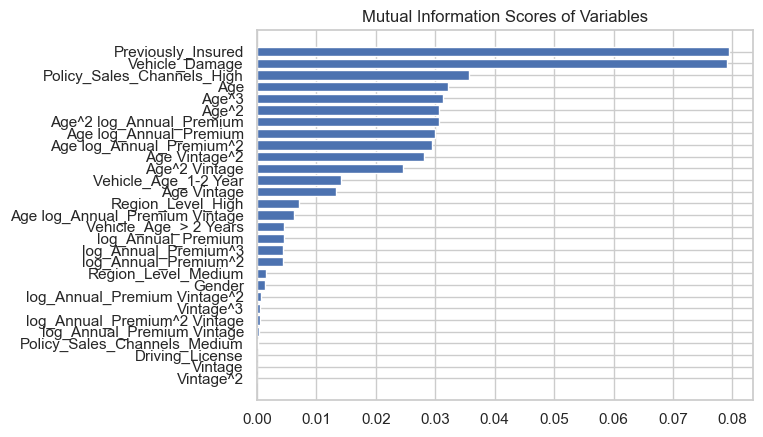

In [43]:
X_poly_quant[dummy_vars] = X_poly_quant[dummy_vars].astype(int)
discrete_features = X_poly_quant.dtypes == int
mi_scores = make_mi_scores(X_poly_quant, y, discrete_features)
plot_scores(mi_scores, title = 'Mutual Information Scores of Variables')

As before, a "visual" feature selection is done: the variables that exhibit an almost zero Mutual Information score are dropped, in order to avoid over-complications of the model: the variables until Gender are kept, the others, with an almost zero score, are dropped.

In [46]:
poly_vars_to_drop = mi_scores.index.to_list()[-8:]
X_poly = X_poly_quant.drop(poly_vars_to_drop, axis = 1)
X_poly.head()

,Age,log_Annual_Premium,Age^2,Age log_Annual_Premium,Age Vintage,log_Annual_Premium^2,Age^3,Age^2 log_Annual_Premium,Age^2 Vintage,Age log_Annual_Premium^2,...,Age Vintage^2,log_Annual_Premium^3,Gender,Previously_Insured,Vehicle_Damage,Vehicle_Age_1-2 Year,Vehicle_Age_> 2 Years,Region_Level_Medium,Region_Level_High,Policy_Sales_Channels_High
0,44.0,10.607921,1936.0,466.748515,9548.0,112.527984,85184.0,20536.934679,420112.0,4951.231288,...,2071916.0,1193.687941,1,0,1,0,1,0,1,1
1,76.0,10.420375,5776.0,791.948482,13908.0,108.584210,438976.0,60188.084658,1057008.0,8252.399983,...,2545164.0,1131.488165,1,0,0,1,0,0,1,1
2,47.0,10.553049,2209.0,495.993280,1269.0,111.366833,103823.0,23311.684147,59643.0,5234.241139,...,34263.0,1175.259588,1,0,1,0,1,0,1,1
3,21.0,10.261826,441.0,215.498348,4263.0,105.305075,9261.0,4525.465315,89523.0,2211.406578,...,865389.0,1080.622370,1,1,0,0,0,1,0,0
4,29.0,10.221796,841.0,296.432079,1131.0,104.485110,24389.0,8596.530283,32799.0,3030.068183,...,44109.0,1068.025458,0,1,0,0,0,0,1,0


### Poly II
Interaction-only model with the dummies (To note that here no Mutual Informration is recovered because it would be a very slow fit: regularization will do the job.

#### Construction of the interaction-only dataset 
Not up to the third degree, just two.

In [47]:
X_copy_for_transformation = X.copy()
poly_int = PolynomialFeatures(degree=2, include_bias=False,interaction_only=True)
X_int = poly_int.fit_transform(X_copy_for_transformation)
poly_int_names = poly_int.get_feature_names_out(X_copy_for_transformation.columns)
X_int = pd.DataFrame(X_int, columns=poly_int_names)
# dropping all zero columns
squared_sum = X_int.apply(np.square).sum(axis=0)
zero_squared_sum_variables = squared_sum[squared_sum == 0]
print(f'X_int.shape Before dropping: {X_int.shape}')
print(f'Variables to drop: {zero_squared_sum_variables.index.tolist()}')
X_int = X_int.drop(zero_squared_sum_variables.index.tolist(), axis = 1)
print(f'X_int.shape After dropping: {X_int.shape}')
X_int.head()

X_int.shape Before dropping: (381109, 91)
Variables to drop: ['Vehicle_Age_1-2 Year Vehicle_Age_> 2 Years', 'Region_Level_Medium Region_Level_High', 'Policy_Sales_Channels_Medium Policy_Sales_Channels_High']
X_int.shape After dropping: (381109, 88)


,Gender,Age,Driving_License,Previously_Insured,Vehicle_Damage,Vintage,Vehicle_Age_1-2 Year,Vehicle_Age_> 2 Years,Region_Level_Medium,Region_Level_High,...,Vehicle_Age_> 2 Years Policy_Sales_Channels_High,Vehicle_Age_> 2 Years log_Annual_Premium,Region_Level_Medium Policy_Sales_Channels_Medium,Region_Level_Medium Policy_Sales_Channels_High,Region_Level_Medium log_Annual_Premium,Region_Level_High Policy_Sales_Channels_Medium,Region_Level_High Policy_Sales_Channels_High,Region_Level_High log_Annual_Premium,Policy_Sales_Channels_Medium log_Annual_Premium,Policy_Sales_Channels_High log_Annual_Premium
0,1.0,44.0,1.0,0.0,1.0,217.0,0.0,1.0,0.0,1.0,...,1.0,10.607921,0.0,0.0,0.000000,0.0,1.0,10.607921,0.0,10.607921
1,1.0,76.0,1.0,0.0,0.0,183.0,1.0,0.0,0.0,1.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,10.420375,0.0,10.420375
2,1.0,47.0,1.0,0.0,1.0,27.0,0.0,1.0,0.0,1.0,...,1.0,10.553049,0.0,0.0,0.000000,0.0,1.0,10.553049,0.0,10.553049
3,1.0,21.0,1.0,1.0,0.0,203.0,0.0,0.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,10.261826,0.0,0.0,0.000000,0.0,0.000000
4,0.0,29.0,1.0,1.0,0.0,39.0,0.0,0.0,0.0,1.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,10.221796,0.0,0.000000


#### Mutual Information Analysis
with interactions between only the quantitative variables

Note that in the graph on the y-axis are not plotted all the variables but in a way that one is printed, one not, one yes, and so on, because otherwise the graph would be unreadable.

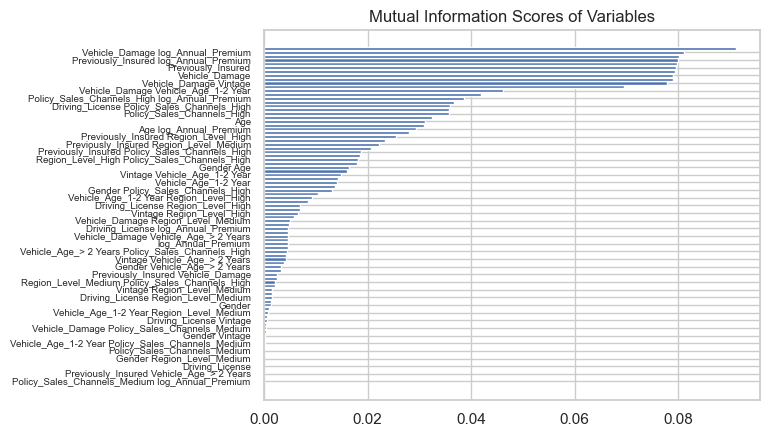

In [85]:
q_int_cols = [col for col in X_int.columns if any(var == col or f' {var} ' in f' {col} ' for var in quantitative_vars)]
dummy_int_cols = [x for x in X_int.columns if x not in q_int_cols]
X_int[dummy_int_cols] = X_int[dummy_int_cols].astype(int)
discrete_features = X_int.dtypes == int
mi_scores = make_mi_scores(X_int, y, discrete_features)
plot_scores(mi_scores, title = 'Mutual Information Scores of Variables')
plt.yticks(np.arange(0, len(mi_scores), 2), fontsize = 7)
plt.show(block=False)

Again, the variables that exhibit an almost zero Mutual Information score are dropped, in order to avoid over-complications of the model: quite arbitrarily, it is chosen to drop the variables that have a score less than 0.001 (in doing so the least informative variable kept in the model is again Gender); in doing so the variables with a percentage of Mutal Information less or equal to 1% with respect the most explicative one are dropped

In [205]:
print(f'Will be dropped {len(mi_scores[mi_scores < 0.001].index.to_list())} variables')
int_vars_to_drop = mi_scores[mi_scores < 0.001].index.to_list()
X_int = X_int.drop(int_vars_to_drop, axis = 1)
max_score = mi_scores[0]
print("\nPercentages of Mutual Information scores with respect to the maximum score of the variables dropped: \n")
print(mi_scores[mi_scores < 0.001]/max_score*100)
X_int.head()

Will be dropped 20 variables

Percentages of Mutual Information scores with respect to the maximum score of the variables dropped: 

Age Policy_Sales_Channels_Medium                      1.058635
Vehicle_Age_1-2 Year Region_Level_Medium              0.843212
Vehicle_Age_> 2 Years Region_Level_Medium             0.585064
Driving_License Vintage                               0.543661
Vintage Policy_Sales_Channels_Medium                  0.456585
Vehicle_Damage Policy_Sales_Channels_Medium           0.449094
Vintage                                               0.393453
Gender Vintage                                        0.290679
Vintage log_Annual_Premium                            0.253353
Vehicle_Age_1-2 Year Policy_Sales_Channels_Medium     0.186331
Vehicle_Age_> 2 Years Policy_Sales_Channels_Medium    0.122909
Policy_Sales_Channels_Medium                          0.111281
Driving_License Policy_Sales_Channels_Medium          0.107002
Gender Region_Level_Medium                      

,Gender,Age,Previously_Insured,Vehicle_Damage,Vehicle_Age_1-2 Year,Vehicle_Age_> 2 Years,Region_Level_Medium,Region_Level_High,Policy_Sales_Channels_High,log_Annual_Premium,...,Vehicle_Age_1-2 Year Policy_Sales_Channels_High,Vehicle_Age_1-2 Year log_Annual_Premium,Vehicle_Age_> 2 Years Region_Level_High,Vehicle_Age_> 2 Years Policy_Sales_Channels_High,Vehicle_Age_> 2 Years log_Annual_Premium,Region_Level_Medium Policy_Sales_Channels_High,Region_Level_Medium log_Annual_Premium,Region_Level_High Policy_Sales_Channels_High,Region_Level_High log_Annual_Premium,Policy_Sales_Channels_High log_Annual_Premium
0,1,44.0,0,1,0,1,0,1,1,10.607921,...,0,0.000000,1,1,10.607921,0,0.000000,1,10.607921,10.607921
1,1,76.0,0,0,1,0,0,1,1,10.420375,...,1,10.420375,0,0,0.000000,0,0.000000,1,10.420375,10.420375
2,1,47.0,0,1,0,1,0,1,1,10.553049,...,0,0.000000,1,1,10.553049,0,0.000000,1,10.553049,10.553049
3,1,21.0,1,0,0,0,1,0,0,10.261826,...,0,0.000000,0,0,0.000000,0,10.261826,0,0.000000,0.000000
4,0,29.0,1,0,0,0,0,1,0,10.221796,...,0,0.000000,0,0,0.000000,0,0.000000,0,10.221796,0.000000


### Poly III
Making both power transformations and interactions

In [161]:
poly_all = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly_int = poly_all.fit_transform(X_poly)
poly_all_names = poly_all.get_feature_names_out(X_poly.columns)
X_poly_int = pd.DataFrame(X_poly_int, columns=poly_all_names)
# dropping all zero columns
squared_sum = X_poly_int.apply(np.square).sum(axis=0)
zero_squared_sum_variables = squared_sum[squared_sum == 0]
print(f'X_poly_int.shape Before dropping: {X_poly_int.shape}')
print(f'Variables to drop: {zero_squared_sum_variables.index.tolist()}')
X_poly_int = X_poly_int.drop(zero_squared_sum_variables.index.tolist(), axis = 1)
print(f'X_int.shape After dropping: {X_poly_int.shape}')
X_poly_int.head()

X_poly_int.shape Before dropping: (381109, 231)
Variables to drop: ['Vehicle_Age_1-2 Year Vehicle_Age_> 2 Years', 'Region_Level_Medium Region_Level_High']
X_int.shape After dropping: (381109, 229)


,Age,log_Annual_Premium,Age^2,Age log_Annual_Premium,Age Vintage,log_Annual_Premium^2,Age^3,Age^2 log_Annual_Premium,Age^2 Vintage,Age log_Annual_Premium^2,...,Vehicle_Damage Region_Level_High,Vehicle_Damage Policy_Sales_Channels_High,Vehicle_Age_1-2 Year Region_Level_Medium,Vehicle_Age_1-2 Year Region_Level_High,Vehicle_Age_1-2 Year Policy_Sales_Channels_High,Vehicle_Age_> 2 Years Region_Level_Medium,Vehicle_Age_> 2 Years Region_Level_High,Vehicle_Age_> 2 Years Policy_Sales_Channels_High,Region_Level_Medium Policy_Sales_Channels_High,Region_Level_High Policy_Sales_Channels_High
0,44.0,10.607921,1936.0,466.748515,9548.0,112.527984,85184.0,20536.934679,420112.0,4951.231288,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,76.0,10.420375,5776.0,791.948482,13908.0,108.584210,438976.0,60188.084658,1057008.0,8252.399983,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,47.0,10.553049,2209.0,495.993280,1269.0,111.366833,103823.0,23311.684147,59643.0,5234.241139,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,21.0,10.261826,441.0,215.498348,4263.0,105.305075,9261.0,4525.465315,89523.0,2211.406578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29.0,10.221796,841.0,296.432079,1131.0,104.485110,24389.0,8596.530283,32799.0,3030.068183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Mutual Information Analysis
Note that on the graph, on the y-axis are not plotted all the variables for readibility as before.

As preliminary step, the columns that contain useless interaction (maybe age with age^2 with something else, so useless repetitions) are found and dropped.

Then 

In [162]:
import re
elements_to_remove = []
for element in X_poly_int.columns.to_list():
    # Using regular expression to find patterns like 'Age^2 Age log_Annual_Premium'
    pattern = re.compile(r'(\b\w+\b)(?=.*\b\1\b)')
    if pattern.search(element):
        elements_to_remove.append(element)
# an example     
elements_to_remove[:20]

['Age Age^2',
 'Age Age log_Annual_Premium',
 'Age Age Vintage',
 'Age Age^3',
 'Age Age^2 log_Annual_Premium',
 'Age Age^2 Vintage',
 'Age Age log_Annual_Premium^2',
 'Age Age log_Annual_Premium Vintage',
 'Age Age Vintage^2',
 'log_Annual_Premium Age log_Annual_Premium',
 'log_Annual_Premium log_Annual_Premium^2',
 'log_Annual_Premium Age^2 log_Annual_Premium',
 'log_Annual_Premium Age log_Annual_Premium^2',
 'log_Annual_Premium Age log_Annual_Premium Vintage',
 'log_Annual_Premium log_Annual_Premium^3',
 'Age^2 Age log_Annual_Premium',
 'Age^2 Age Vintage',
 'Age^2 log_Annual_Premium^2',
 'Age^2 Age^3',
 'Age^2 Age^2 log_Annual_Premium']

Then the usual Mutual Information is retrieved, and will be cutted the variables with a score less than 0.005: this is arbitrary like before, just because it seems a reasonable thresholds after inspecting the relativeness. The threshold is a bit higher, in order to try to semplifying the fitting of the models and the CV that will be made after.

Total columns before: (381109, 229)
Total columns after: (381109, 153)


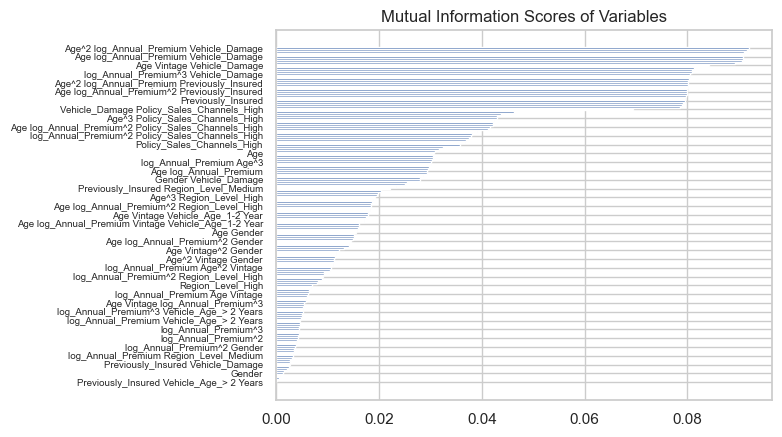

In [164]:
print(f'Total columns before: {X_poly_int.shape}')
X_poly_int = X_poly_int.drop(elements_to_remove, axis = 1)
print(f'Total columns after: {X_poly_int.shape}')
quantitative_vars_new = quantitative_vars + ['Age^2', 'Age^3', 'log_Annual_Premium^2', 'log_Annual_Premium^3',
                                            'Vintage^2','Vintage^3']
q_poly_int_cols = [col for col in X_poly_int.columns if any(var == col or f' {var} ' in f' {col} ' for var in quantitative_vars_new)]
dummy_poly_int_cols = [x for x in X_poly_int.columns if x not in q_poly_int_cols]
# to verify correctness
# len(dummy_poly_int_cols) + len(q_poly_int_cols)
X_poly_int[dummy_poly_int_cols] = X_poly_int[dummy_poly_int_cols].astype(int)
discrete_features = X_poly_int.dtypes == int
mi_scores_poly_int = make_mi_scores(X_poly_int, y, discrete_features)
plot_scores(mi_scores_poly_int, title = 'Mutual Information Scores of Variables')
plt.yticks(np.arange(0, len(mi_scores_poly_int), 4), fontsize = 7)
plt.show(block=False)

In [208]:
print(f'Will be dropped {len(mi_scores_poly_int[mi_scores_poly_int < 0.005].index.to_list())} variables')
max_score = mi_scores_poly_int[0]
print("\nPercentages of Mutual Information scores with respect to the maximum score of the variables dropped: \n")
print(mi_scores_poly_int[mi_scores_poly_int < 0.005]/max_score * 100)
poly_int_vars_to_drop = mi_scores_poly_int[mi_scores_poly_int < 0.005].index.to_list()
X_poly_int = X_poly_int.drop(poly_int_vars_to_drop, axis = 1)
X_poly_int.head()

Will be dropped 31 variables

Percentages of Mutual Information scores with respect to the maximum score of the variables dropped: 

Vehicle_Damage Region_Level_Medium                      5.424127
Age Vintage Region_Level_Medium                         5.263456
log_Annual_Premium Vehicle_Age_> 2 Years                5.031936
Vehicle_Damage Vehicle_Age_> 2 Years                    5.015979
Vehicle_Age_> 2 Years                                   5.006313
Vehicle_Age_> 2 Years Policy_Sales_Channels_High        4.889386
log_Annual_Premium^3                                    4.852294
Age log_Annual_Premium Vintage Vehicle_Age_> 2 Years    4.811442
Age log_Annual_Premium Vintage Gender                   4.725879
Gender Region_Level_High                                4.687869
log_Annual_Premium^2                                    4.549890
Age Vehicle_Age_> 2 Years                               4.333436
Vehicle_Age_> 2 Years Region_Level_High                 4.246357
log_Annual_Premium Gen

,Age,log_Annual_Premium,Age^2,Age log_Annual_Premium,Age Vintage,Age^3,Age^2 log_Annual_Premium,Age^2 Vintage,Age log_Annual_Premium^2,Age log_Annual_Premium Vintage,...,Previously_Insured Vehicle_Age_1-2 Year,Previously_Insured Region_Level_Medium,Previously_Insured Region_Level_High,Previously_Insured Policy_Sales_Channels_High,Vehicle_Damage Vehicle_Age_1-2 Year,Vehicle_Damage Region_Level_High,Vehicle_Damage Policy_Sales_Channels_High,Vehicle_Age_1-2 Year Region_Level_High,Vehicle_Age_1-2 Year Policy_Sales_Channels_High,Region_Level_High Policy_Sales_Channels_High
0,44.0,10.607921,1936.0,466.748515,9548.0,85184.0,20536.934679,420112.0,4951.231288,101284.427847,...,0,0,0,0,0,1,1,0,0,1
1,76.0,10.420375,5776.0,791.948482,13908.0,438976.0,60188.084658,1057008.0,8252.399983,144926.572269,...,0,0,0,0,0,0,0,1,1,1
2,47.0,10.553049,2209.0,495.993280,1269.0,103823.0,23311.684147,59643.0,5234.241139,13391.818553,...,0,0,0,0,0,1,1,0,0,1
3,21.0,10.261826,441.0,215.498348,4263.0,9261.0,4525.465315,89523.0,2211.406578,43746.164715,...,0,1,0,0,0,0,0,0,0,0
4,29.0,10.221796,841.0,296.432079,1131.0,24389.0,8596.530283,32799.0,3030.068183,11560.851071,...,0,0,1,0,0,0,0,0,0,0


### CV of the poly models

In [238]:
X_train_poly, X_test_poly, y_train, y_test = train_test_splitting(X_poly, y)
X_int_train, X_int_test, y_train, y_test = train_test_splitting(X_int, y)
X_poly_int_train, X_poly_int_test, y_train, y_test = train_test_splitting(X_poly_int, y)

models = [
    LogisticRegression(penalty=None, max_iter=500),
    LogisticRegression(penalty='l2', C=10, max_iter=500),
    LogisticRegression(penalty='l2', C=1, max_iter=500),
    LogisticRegression(penalty='l2', C=0.1, max_iter=500),
    LogisticRegression(penalty='l2', C=0.01, max_iter=500),
    LogisticRegression(penalty='l2', C=0.001, max_iter=500),
    LogisticRegression(penalty='l2', C=0.0001, max_iter=500),
    LogisticRegression(penalty='l2', C=0.00001, max_iter=500)
]

mod_names_poly = [f'lr_poly_l2_{alpha}' for alpha in [''] + ['10', '1', '.1', '.01', '.001', '.0001', '.00001']]

mod_names_int = [f'lr_int_l2_{alpha}' for alpha in [''] + ['10', '1', '.1', '.01', '.001', '.0001', '.00001']]

mod_names_poly_int = [f'lr_poly_int_l2_{alpha}' for alpha in [''] + ['10', '1', '.1', '.01', '.001', '.0001', '.00001']]

# CV
roc_auc_scores_poly = {}
roc_auc_scores_int = {}
roc_auc_scores_poly_int = {}
precision_recall_auc_scores_poly = {}
precision_recall_auc_scores_int = {}
precision_recall_auc_scores_poly_int = {}
cv_res_poly = {}
cv_res_int = {}
cv_res_poly_int = {}

for i, model in enumerate(models):
    (cv_res_poly[mod_names_poly[i]],
    precision_recall_auc_scores_poly[mod_names_poly[i]],
    roc_auc_scores_poly[mod_names_poly[i]]) = cross_validator_with_thresholds(model, X_train_poly, 
                                                                         y_train, n_folds=5, 
                                    oversampling=True, print_cv=True, print_shape=True)
    (cv_res_int[mod_names_int[i]],
    precision_recall_auc_scores_int[mod_names_int[i]],
    roc_auc_scores_int[mod_names_int[i]]) = cross_validator_with_thresholds(model, X_int_train, 
                                                                       y_train, n_folds=5, 
                                    oversampling=True, print_cv=True, print_shape=True)
    (cv_res_poly_int[mod_names_poly_int[i]],
    precision_recall_auc_scores_poly_int[mod_names_poly_int[i]],
    roc_auc_scores_poly_int[mod_names_poly_int[i]]) = cross_validator_with_thresholds(model, X_poly_int_train, 
                                                                       y_train, n_folds=5, 
                                    oversampling=True, print_cv=True, print_shape=True)
    
    print(f'\nCross-validated the {i+1}th model of the list for the three datasets')
    print('------------------------------------------------------')

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 21), X resampled shape: (428032, 21),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 68), X resampled shape: (428032, 68),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 122), X resampled shape: (428032, 122),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)

Cross-validated the 1th model of the list for the three datasets
------------------------------------------------------
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/

C:\Users\lucia\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 122), X resampled shape: (428032, 122),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)

Cross-validated the 2th model of the list for the three datasets
------------------------------------------------------
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 21), X resampled shape: (428032, 21),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 68), X resampled shape: (428032, 68),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequen

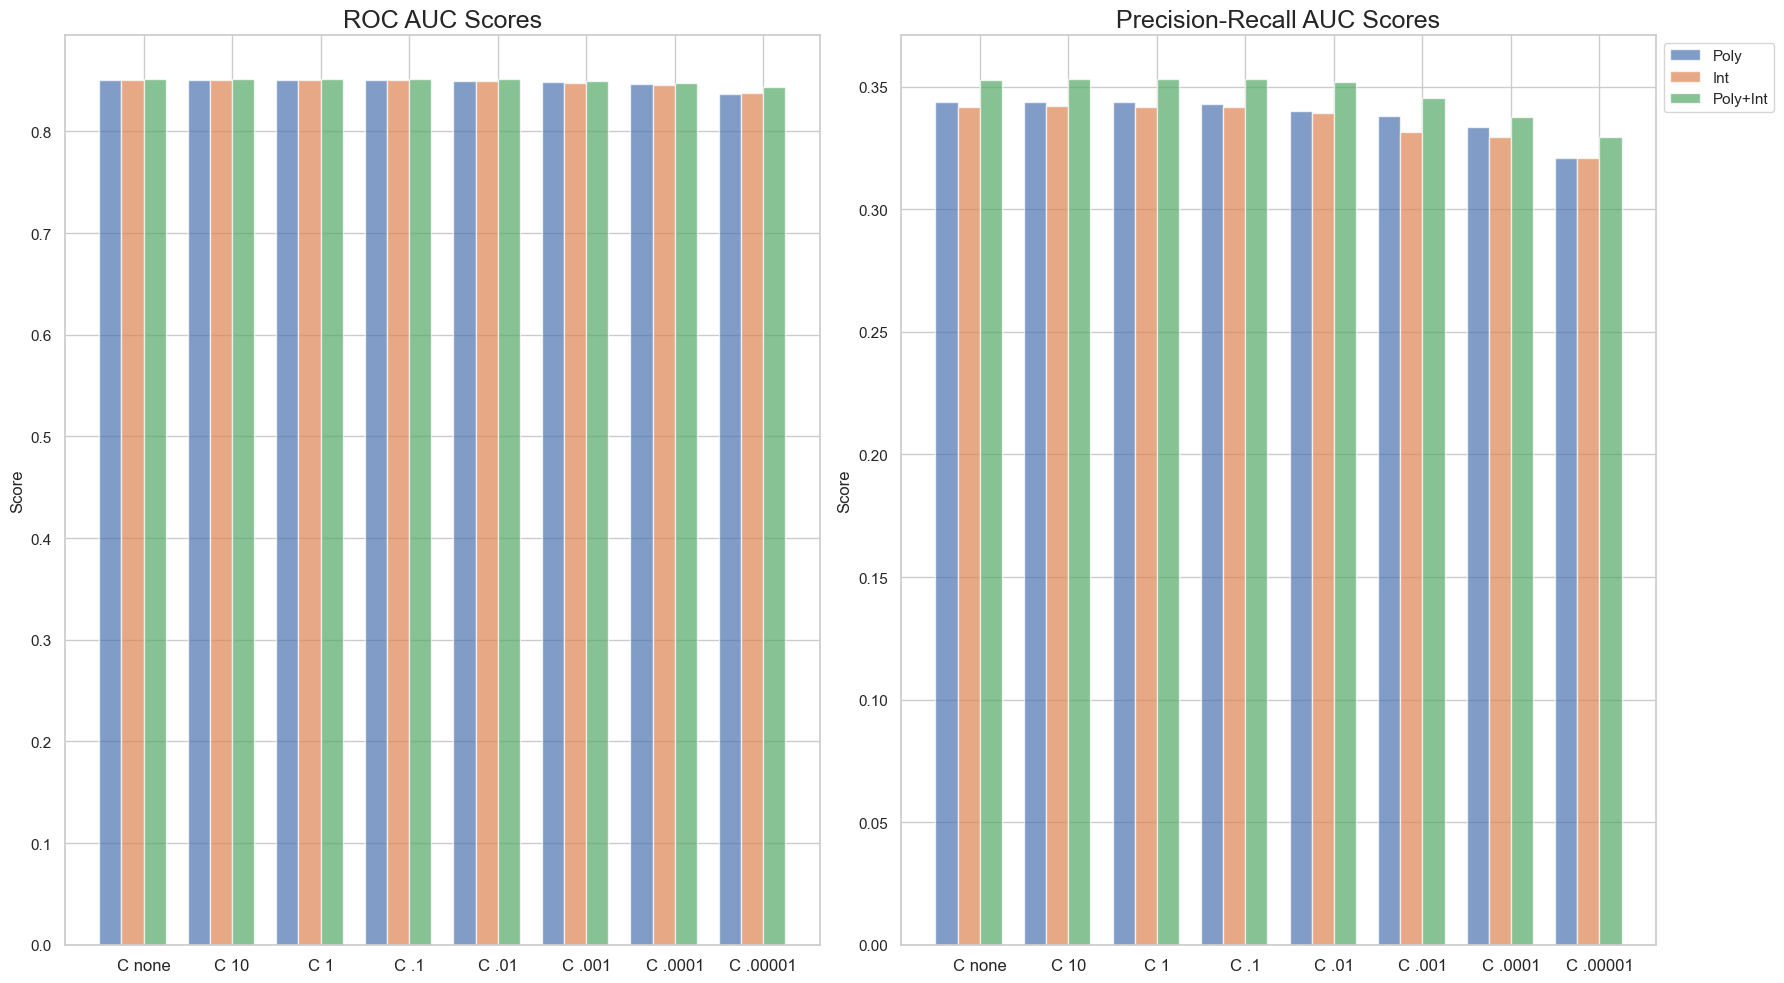

In [219]:
# Data
x_values = np.arange(len(models))
bar_width = 0.25
C_penalties = ['C none', 'C 10', 'C 1', 'C .1', 'C .01', 'C .001', 'C .0001', 'C .00001']

# Plotting for roc_auc_scores
plt.figure(figsize=(18,10))

# ROC AUC Scores
plt.subplot(1, 2, 1)
plt.bar(x_values, list(roc_auc_scores_poly.values()), width=bar_width, align='center', alpha=0.7, label='Poly')
plt.bar(x_values + bar_width, list(roc_auc_scores_int.values()), width=bar_width, align='center', alpha=0.7, label='Int')
plt.bar(x_values + 2 * bar_width, list(roc_auc_scores_poly_int.values()), width=bar_width, align='center', alpha=0.7, label='Poly+Int')
plt.xticks(x_values + 1.5 * bar_width, C_penalties, fontsize=12)
plt.title('ROC AUC Scores', fontsize=18)
plt.ylabel('Score')

# Precision-Recall AUC Scores
plt.subplot(1, 2, 2)
plt.bar(x_values, list(precision_recall_auc_scores_poly.values()), width=bar_width, align='center', alpha=0.7, label='Poly')
plt.bar(x_values + bar_width, list(precision_recall_auc_scores_int.values()), width=bar_width, align='center', alpha=0.7, label='Int')
plt.bar(x_values + 2 * bar_width, list(precision_recall_auc_scores_poly_int.values()), width=bar_width, align='center', alpha=0.7, label='Poly+Int')
plt.xticks(x_values + 1.5 * bar_width, C_penalties, fontsize=12)
plt.title('Precision-Recall AUC Scores', fontsize=18)
plt.ylabel('Score')

# Adjust legend position for the first two plots
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [221]:
# Precision-Recall AUC Scores for poly
pr_scores_poly_df = pd.DataFrame(list(precision_recall_auc_scores_poly.items()), columns=['Model', 'Precision_Recall_AUC_Score'])
pr_scores_poly_df = pr_scores_poly_df.sort_values(by='Precision_Recall_AUC_Score', ascending=False)

# Precision-Recall AUC Scores for int
pr_scores_int_df = pd.DataFrame(list(precision_recall_auc_scores_int.items()), columns=['Model', 'Precision_Recall_AUC_Score'])
pr_scores_int_df = pr_scores_int_df.sort_values(by='Precision_Recall_AUC_Score', ascending=False)

# Precision-Recall AUC Scores for poly+int
pr_scores_poly_int_df = pd.DataFrame(list(precision_recall_auc_scores_poly_int.items()), columns=['Model', 'Precision_Recall_AUC_Score'])
pr_scores_poly_int_df = pr_scores_poly_int_df.sort_values(by='Precision_Recall_AUC_Score', ascending=False)

# Display DataFrames
print("Precision-Recall AUC Scores (Poly), from the higher area to the lower:\n", pr_scores_poly_df)
print("\nPrecision-Recall AUC Scores (Int), from the higher area to the lower:\n", pr_scores_int_df)
print("\nPrecision-Recall AUC Scores (Poly+Int), from the higher area to the lower:\n", pr_scores_poly_int_df)


Precision-Recall AUC Scores (Poly), from the higher area to the lower:
                Model  Precision_Recall_AUC_Score
0        lr_poly_l2_                    0.343930
1      lr_poly_l2_10                    0.343743
2       lr_poly_l2_1                    0.343632
3      lr_poly_l2_.1                    0.342766
4     lr_poly_l2_.01                    0.340024
5    lr_poly_l2_.001                    0.337898
6   lr_poly_l2_.0001                    0.333516
7  lr_poly_l2_.00001                    0.320842

Precision-Recall AUC Scores (Int), from the higher area to the lower:
               Model  Precision_Recall_AUC_Score
1      lr_int_l2_10                    0.341982
0        lr_int_l2_                    0.341802
2       lr_int_l2_1                    0.341680
3      lr_int_l2_.1                    0.341587
4     lr_int_l2_.01                    0.339264
5    lr_int_l2_.001                    0.331470
6   lr_int_l2_.0001                    0.329423
7  lr_int_l2_.00001            

## Graphical analysis of ROC and Precision-Recall curves

The preliminary step is fitting a model (using the train and test sets), to have one value for the AUCs and to be able to plot the curves. This is done for four different models, chosen among the ones where the k-fold cv was performed.

In [291]:
evaluators_poly = {}
evaluators_int = {}
evaluators_poly_int = {}

models = [
    LogisticRegression(penalty=None, max_iter=500, class_weight='balanced'),
    LogisticRegression(penalty='l2', C=10, max_iter=500, class_weight='balanced'),
    LogisticRegression(penalty='l2', C=0.1, max_iter=500, class_weight='balanced'),
    LogisticRegression(penalty='l2', C=0.0001, max_iter=500, class_weight='balanced')
]
mod_names = ['lr', 'lr_l2_10', 'lr_l2_.1', 'lr_l2_.0001']

for i, model in enumerate(models):
    model.fit(X_train_poly, y_train)
    y_pred_proba_poly = model.predict_proba(X_test_poly)
    
    model.fit(X_int_train, y_train)
    y_pred_proba_int = model.predict_proba(X_int_test)
    
    model.fit(X_poly_int_train, y_train)
    y_pred_proba_poly_int = model.predict_proba(X_poly_int_test)
    
    print('------------------------------------------------------')
    print(f'\nfitted the {i+1}th model of the list')
    
    evaluators_poly[mod_names[i]] = ThresholdEvaluatorLogReg(y_test, y_pred_proba_poly)
    evaluators_int[mod_names[i]] = ThresholdEvaluatorLogReg(y_test, y_pred_proba_int)
    evaluators_poly_int[mod_names[i]] = ThresholdEvaluatorLogReg(y_test, y_pred_proba_poly_int)



------------------------------------------------------

fitted the 1th model of the list
------------------------------------------------------

fitted the 2th model of the list
------------------------------------------------------

fitted the 3th model of the list
------------------------------------------------------

fitted the 4th model of the list


### ROC and Precision-Recall

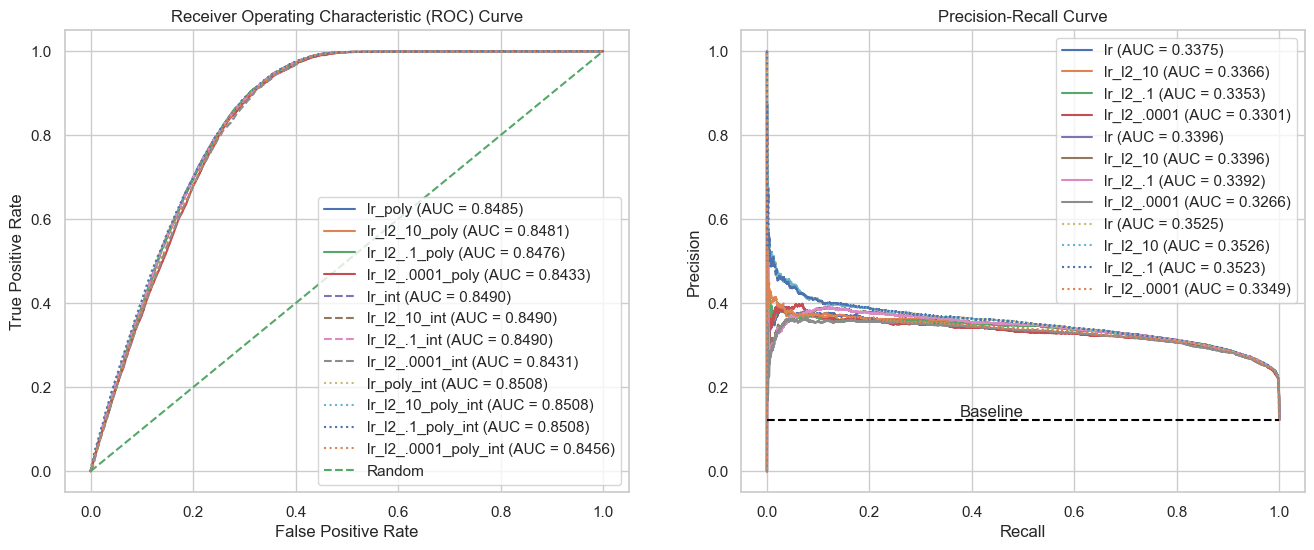

In [294]:
# Plot ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot ROC curves for evaluators_poly
for model_name in mod_names:
    fpr, tpr, _ = roc_curve(y_test, evaluators_poly[model_name].get_pred_probs())
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{model_name}_poly (AUC = {roc_auc:.4f})')
# Plot ROC curves for evaluators_int
for model_name in mod_names:
    fpr, tpr, _ = roc_curve(y_test, evaluators_int[model_name].get_pred_probs())
    roc_auc_all = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{model_name}_int (AUC = {roc_auc_all:.4f})', linestyle='--')
# Plot ROC curves for evaluators_poly_int
for model_name in mod_names:
    fpr, tpr, _ = roc_curve(y_test, evaluators_poly_int[model_name].get_pred_probs())
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{model_name}_poly_int (AUC = {roc_auc:.4f})', linestyle=':')

ax1.plot([0, 1], [0, 1], linestyle='--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')

# Plot Precision-Recall curves for evaluators_poly
for model_name in mod_names:
    precision, recall, _ = precision_recall_curve(y_test, evaluators_poly[model_name].get_pred_probs())
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.4f})')
# Plot Precision-Recall curves for evaluators_int
for model_name in mod_names:
    precision, recall, _ = precision_recall_curve(y_test, evaluators_int[model_name].get_pred_probs())
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.4f})')
# Plot Precision-Recall curves for evaluators_poly_int
for model_name in mod_names:
    precision, recall, _ = precision_recall_curve(y_test, evaluators_poly_int[model_name].get_pred_probs())
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.4f})', linestyle=':')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='upper right')
ax2.set_title('Precision-Recall Curve')
baseline = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [baseline, baseline], linestyle='--', color='black') 
ax2.text(0.5, baseline, 'Baseline', verticalalignment='bottom', horizontalalignment='right')

plt.show()

As it can be seen the different models show a very similar performance, regardelss the penalization or the transformation performed on the data.

## Graphical analysis of how metrics change according to the thresholds

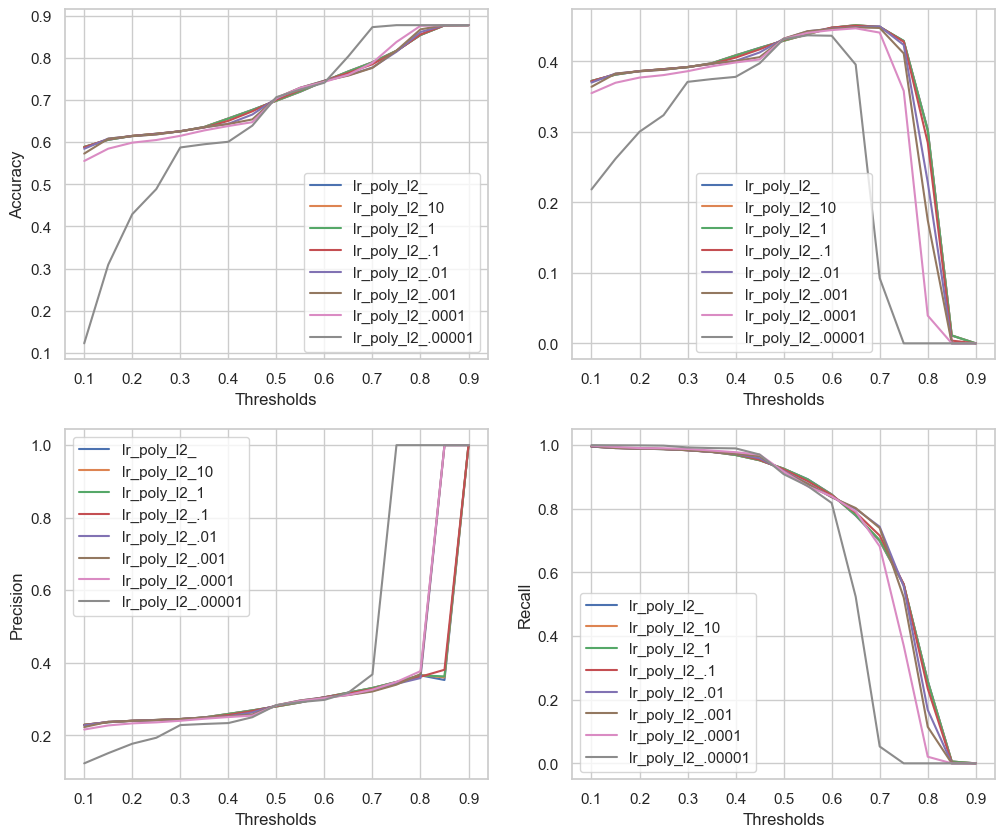

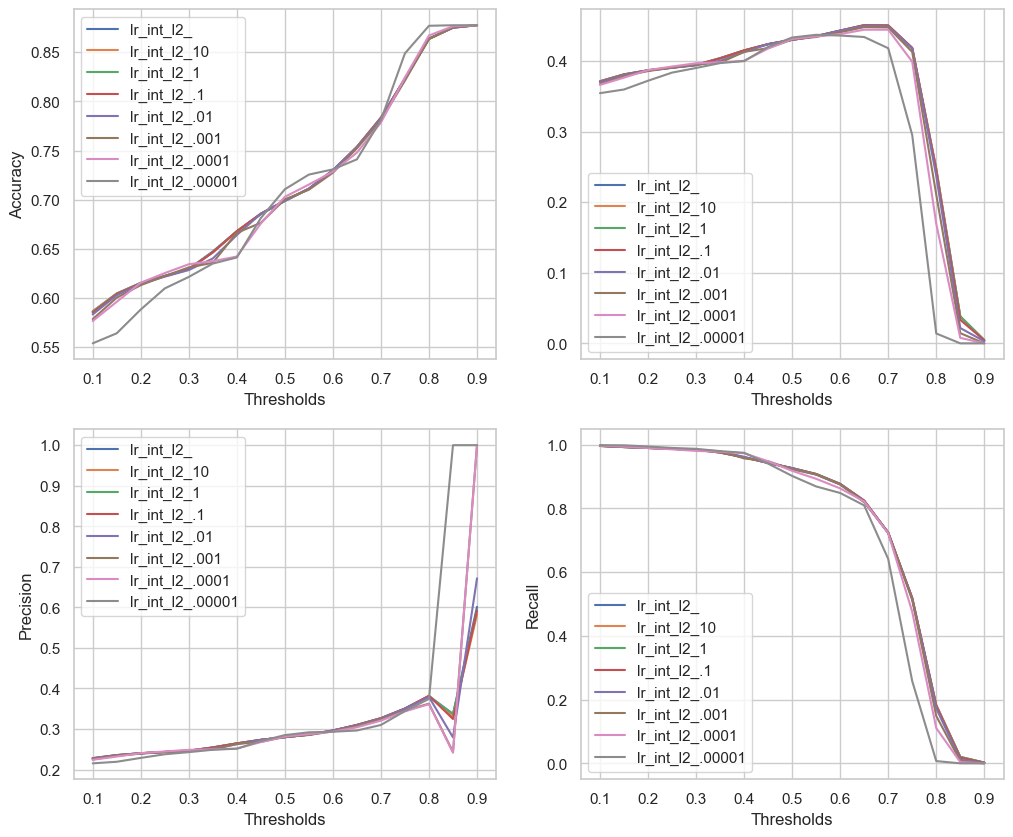

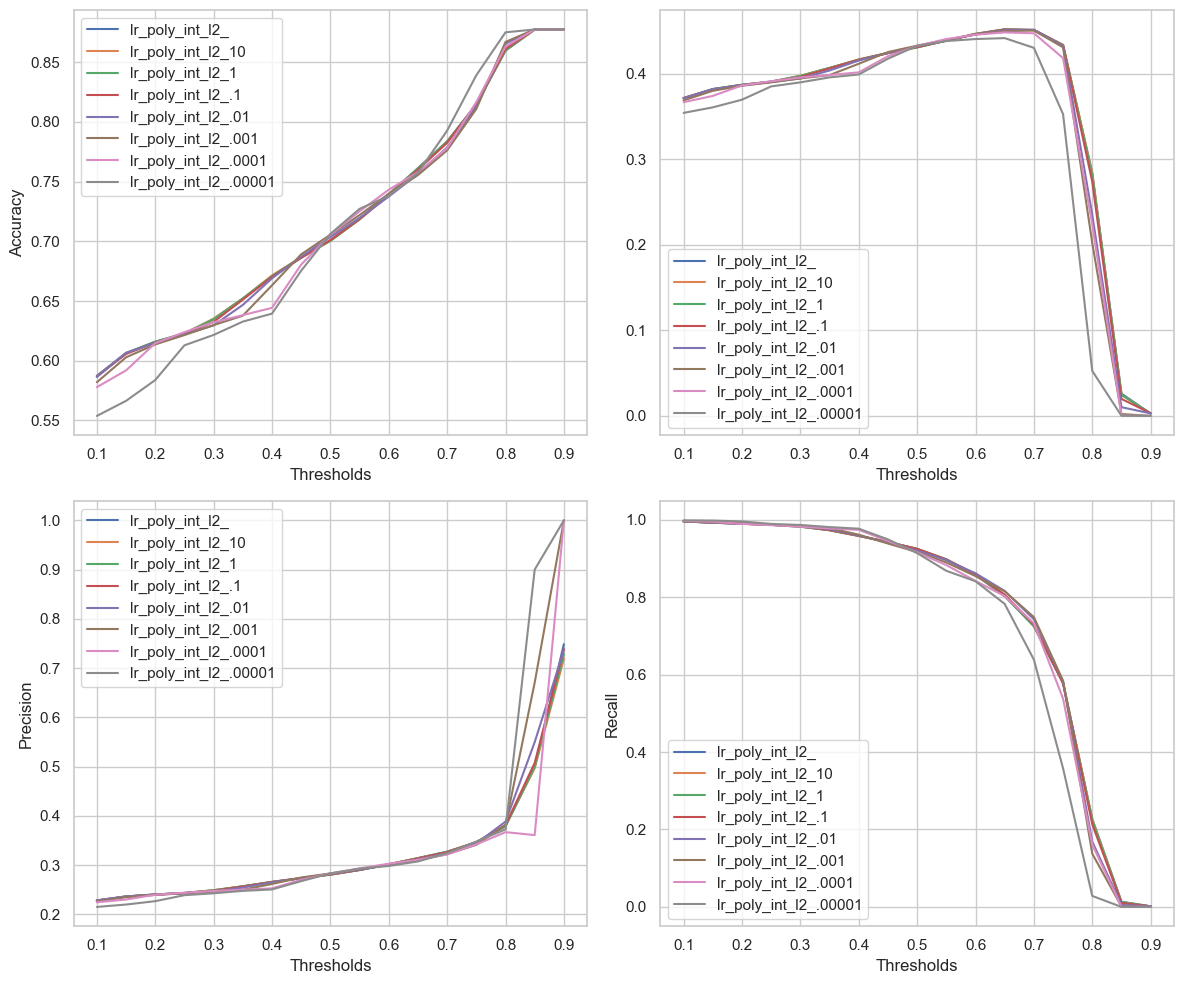

In [264]:
m_poly = list(cv_res_poly.keys())
m_int = list(cv_res_int.keys())
m_poly_int = list(cv_res_poly_int.keys())
# Define the threshold values
thresholds = cv_res_poly['lr_poly_l2_'].index.to_list()
# Define the models
models = list(cv_res_poly.keys())
# Define metrics
metrics = cv_res_poly['lr_poly_l2_'].columns.to_list()
fig, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))#, sharex=True)
fig, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))#, sharex=True)
fig, axes3 = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))#, sharex=True)
# plots
for i in range(len(models)):
    axes1[0, 0].plot(thresholds, cv_res_poly[m_poly[i]]['Accuracy on Test'].values, label=m_poly[i])
    axes1[0, 1].plot(thresholds, cv_res_poly[m_poly[i]]['f1 on Test'].values, label=m_poly[i])
    axes1[1, 0].plot(thresholds, cv_res_poly[m_poly[i]]['Precision on Test'].values, label=m_poly[i])
    axes1[1, 1].plot(thresholds, cv_res_poly[m_poly[i]]['Recall on Test'].values, label=m_poly[i])
        
    axes2[0, 0].plot(thresholds, cv_res_int[m_int[i]]['Accuracy on Test'].values, label=m_int[i])
    axes2[0, 1].plot(thresholds, cv_res_int[m_int[i]]['f1 on Test'].values, label=m_int[i])
    axes2[1, 0].plot(thresholds, cv_res_int[m_int[i]]['Precision on Test'].values, label=m_int[i])
    axes2[1, 1].plot(thresholds, cv_res_int[m_int[i]]['Recall on Test'].values, label=m_int[i])
    
    axes3[0, 0].plot(thresholds, cv_res_poly_int[m_poly_int[i]]['Accuracy on Test'].values, label=m_poly_int[i])
    axes3[0, 1].plot(thresholds, cv_res_poly_int[m_poly_int[i]]['f1 on Test'].values, label=m_poly_int[i])
    axes3[1, 0].plot(thresholds, cv_res_poly_int[m_poly_int[i]]['Precision on Test'].values, label=m_poly_int[i])
    axes3[1, 1].plot(thresholds, cv_res_poly_int[m_poly_int[i]]['Recall on Test'].values, label=m_poly_int[i])
# labels
axes1[0, 0].set_ylabel('Accuracy')
axes2[0, 0].set_ylabel('Accuracy')
axes3[0, 0].set_ylabel('Accuracy')

axes1[1, 0].set_ylabel('Precision')
axes2[1, 0].set_ylabel('Precision')
axes3[1, 0].set_ylabel('Precision')

axes1[1, 1].set_ylabel('Recall')
axes2[1, 1].set_ylabel('Recall')
axes3[1, 1].set_ylabel('Recall')

for r in range(0,2):
    for c in range(0,2):
        axes1[r, c].set_xlabel('Thresholds')
        axes2[r, c].set_xlabel('Thresholds')
        axes3[r, c].set_xlabel('Thresholds')
        
# legend
for r in range(0,2):
    for c in range(0,2):
        axes1[r, c].legend(loc='best')
        axes2[r, c].legend(loc='best')
        axes3[r, c].legend(loc='best')
        
plt.tight_layout()
plt.show()


In those graphs it is shown how according to the threshold the model metrics change. They are almost identical around the threshold values 0.3/0.7, and start to diverge at extreme threshold values,and this is not so much of interest.

## Choosing the threshold and the final model

In every single model the big weakness is the low precision: while showing a good behaviour in the recover of the true positives out of the real positives (recall), the true positives out of the total positive predicted are always below 50%.

Now it is only a matter of choosing the best threshold in order to try to get the better model, among the best models according to the regularization factor for each dataset used (so not transformed and transformed)

The final comparison will be using the X dataset, so the dataset where some featuers were dropped but not transformations were performed, and the X_int_poly dataset, with polynomial and interaction terms (to which, again, a "hand" regularization has been performed).

### Threshold metrics for the logistic regression
X data, C = 0.001
X_int_poly data, C = 0.01

In [332]:
cols = ['Accuracy X', 'Recall X', 'Precision X', 'f1 X',
       'Accuracy X_int_poly', 'Recall X_int_poly', 'Precision X_int_poly','f1 X_int_poly']
cv_comparison_df = pd.concat([cv_res['lr_l2_.001'],cv_res_poly_int['lr_poly_int_l2_.01']], axis = 1)
cv_comparison_df.columns = cols
cv_comparison_df.round(3)

,Accuracy X,Recall X,Precision X,f1 X,Accuracy X_int_poly,Recall X_int_poly,Precision X_int_poly,f1 X_int_poly
Thresholds,,,,,,,,
0.10,0.577,0.996,0.224,0.366,0.587,0.996,0.228,0.371
0.15,0.607,0.990,0.236,0.382,0.607,0.992,0.237,0.382
0.20,0.612,0.989,0.239,0.385,0.615,0.990,0.240,0.387
0.25,0.618,0.988,0.241,0.388,0.622,0.987,0.243,0.390
0.30,0.626,0.985,0.245,0.392,0.630,0.984,0.247,0.394
0.35,0.635,0.980,0.249,0.397,0.647,0.976,0.255,0.404
0.40,0.641,0.976,0.251,0.400,0.669,0.959,0.265,0.415
0.45,0.657,0.959,0.258,0.406,0.687,0.940,0.274,0.424
0.50,0.702,0.916,0.280,0.429,0.704,0.920,0.282,0.432


It can be seen that between the two models there are not lots of differences. Before taking any decision a further try is performed.

## trying with more severe feature selection

By seeing the Mutual Information scores obtained previously, it is decided to drop more variables to see if the precision can be improved (so if overfitting, of which this low precision may be a signal, can be reduced). Only the higher scoring variables will be kept for both not-transformed and polynomial-transformed data.

#### Dataset pruned

In [337]:
X_pruned = X[['Age', 'Previously_Insured', 'Vehicle_Damage', 'Policy_Sales_Channels_High','Vehicle_Age_1-2 Year',
'Region_Level_High', 'Vehicle_Age_> 2 Years','log_Annual_Premium']]

#### Dataset pruned with polynomial transformation (including interactions) (degree = 3)

In [338]:
poly_pruned = PolynomialFeatures(degree=3, include_bias=False)
X_to_transform_pruned = X_pruned.copy()
X_poly_int_pruned = poly_pruned.fit_transform(X_to_transform_pruned)
poly_all_names_pruned = poly_pruned.get_feature_names_out(X_to_transform_pruned.columns)
X_poly_int_pruned = pd.DataFrame(X_poly_int_pruned, columns=poly_all_names_pruned)
X_poly_int_pruned
# dropping all zero columns
squared_sum_pruned = X_poly_int_pruned.apply(np.square).sum(axis=0)
zero_squared_sum_variables_pruned = squared_sum_pruned[squared_sum_pruned == 0]
print(f'X_poly_int.shape Before dropping: {X_poly_int_pruned.shape}')
print(f'Variables to drop: {zero_squared_sum_variables_pruned.index.tolist()}')
X_poly_int_pruned = X_poly_int_pruned.drop(zero_squared_sum_variables_pruned.index.tolist(), axis = 1)
print(f'X_int.shape After dropping: {X_poly_int_pruned.shape}')
X_poly_int_pruned.head()

X_poly_int.shape Before dropping: (381109, 164)
Variables to drop: ['Vehicle_Age_1-2 Year Vehicle_Age_> 2 Years', 'Age Vehicle_Age_1-2 Year Vehicle_Age_> 2 Years', 'Previously_Insured Vehicle_Age_1-2 Year Vehicle_Age_> 2 Years', 'Vehicle_Damage Vehicle_Age_1-2 Year Vehicle_Age_> 2 Years', 'Policy_Sales_Channels_High Vehicle_Age_1-2 Year Vehicle_Age_> 2 Years', 'Vehicle_Age_1-2 Year^2 Vehicle_Age_> 2 Years', 'Vehicle_Age_1-2 Year Region_Level_High Vehicle_Age_> 2 Years', 'Vehicle_Age_1-2 Year Vehicle_Age_> 2 Years^2', 'Vehicle_Age_1-2 Year Vehicle_Age_> 2 Years log_Annual_Premium']
X_int.shape After dropping: (381109, 155)


,Age,Previously_Insured,Vehicle_Damage,Policy_Sales_Channels_High,Vehicle_Age_1-2 Year,Region_Level_High,Vehicle_Age_> 2 Years,log_Annual_Premium,Age^2,Age Previously_Insured,...,Region_Level_High^3,Region_Level_High^2 Vehicle_Age_> 2 Years,Region_Level_High^2 log_Annual_Premium,Region_Level_High Vehicle_Age_> 2 Years^2,Region_Level_High Vehicle_Age_> 2 Years log_Annual_Premium,Region_Level_High log_Annual_Premium^2,Vehicle_Age_> 2 Years^3,Vehicle_Age_> 2 Years^2 log_Annual_Premium,Vehicle_Age_> 2 Years log_Annual_Premium^2,log_Annual_Premium^3
0,44.0,0.0,1.0,1.0,0.0,1.0,1.0,10.607921,1936.0,0.0,...,1.0,1.0,10.607921,1.0,10.607921,112.527984,1.0,10.607921,112.527984,1193.687941
1,76.0,0.0,0.0,1.0,1.0,1.0,0.0,10.420375,5776.0,0.0,...,1.0,0.0,10.420375,0.0,0.000000,108.584210,0.0,0.000000,0.000000,1131.488165
2,47.0,0.0,1.0,1.0,0.0,1.0,1.0,10.553049,2209.0,0.0,...,1.0,1.0,10.553049,1.0,10.553049,111.366833,1.0,10.553049,111.366833,1175.259588
3,21.0,1.0,0.0,0.0,0.0,0.0,0.0,10.261826,441.0,21.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1080.622370
4,29.0,1.0,0.0,0.0,0.0,1.0,0.0,10.221796,841.0,29.0,...,1.0,0.0,10.221796,0.0,0.000000,104.485110,0.0,0.000000,0.000000,1068.025458


## Mutual Information plots
Just to have an idea (they will be the same as before) and not need to go back. 

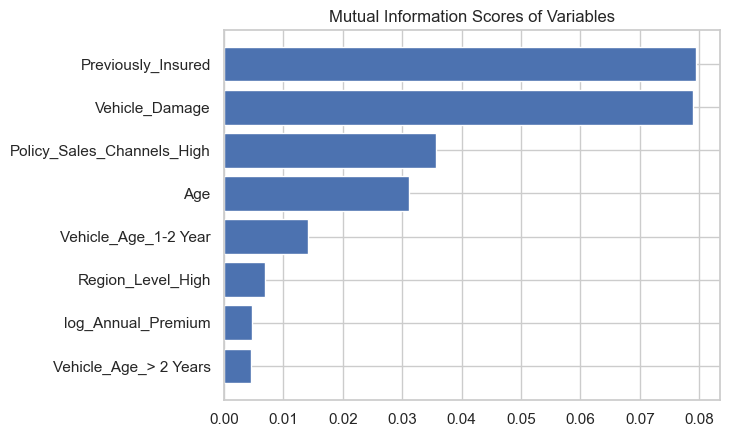

In [345]:
q_cols_pruned = ['Age', 'log_Annual_Premium']
# changing into float
X_pruned.loc[:, q_cols_pruned] = X_pruned.loc[:, q_cols_pruned].astype(float)
#changing into int
cols_not_q = [x for x in X_pruned.columns if x not in q_cols_pruned]
X_pruned.loc[:, cols_not_q] = X_pruned[cols_not_q].astype(int)
#getting dummies for the mask, necessary for the function 
discrete_features_pruned = X_pruned.dtypes == int
mi_scores = make_mi_scores(X_pruned, y, discrete_features_pruned)
plot_scores(mi_scores, title = 'Mutual Information Scores of Variables')

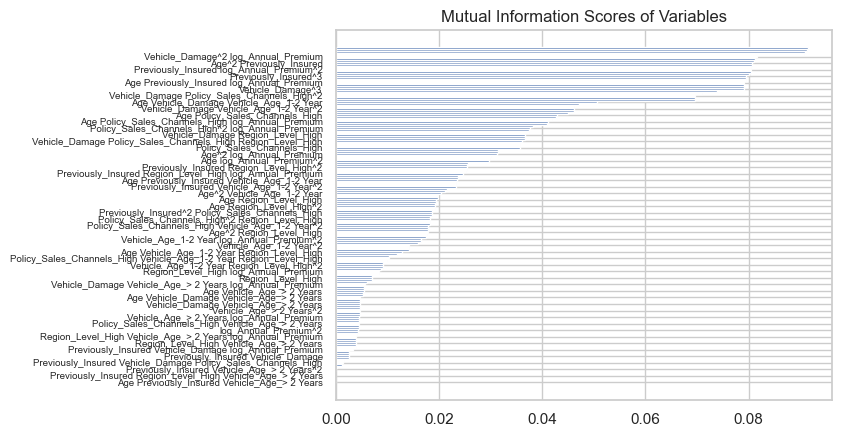

In [356]:
q_cols_pruned_new = q_cols_pruned + ['Age^2', 'Age^3', 'log_Annual_Premium^2', 'log_Annual_Premium^3']
q_cols_pruned_new_also_interactions = [col for col in X_poly_int_pruned.columns if any(var == col or f' {var} ' in f' {col} ' for var in q_cols_pruned_new)]
dummy_poly_int_cols_pruned = [x for x in X_poly_int_pruned.columns if x not in q_cols_pruned_new_also_interactions]
# # to verify correctness
(len(dummy_poly_int_cols_pruned) + len(q_cols_pruned_new_also_interactions)) == X_poly_int_pruned.shape[1]

X_poly_int_pruned[dummy_poly_int_cols_pruned] = X_poly_int_pruned[dummy_poly_int_cols_pruned].astype(int)
discrete_features_poly_int_pruned = X_poly_int_pruned.dtypes == int

mi_scores_poly_int_pruned = make_mi_scores(X_poly_int_pruned, y, discrete_features_poly_int_pruned)
plot_scores(mi_scores_poly_int_pruned, title = 'Mutual Information Scores of Variables')
plt.yticks(np.arange(0, len(mi_scores_poly_int), 3), fontsize = 7)
plt.show(block=False)

In [406]:
max_score_pruned = mi_scores_poly_int_pruned[0]
thr_pruning = max_score_pruned*(1/3)
print(f'Will be dropped \
{len(mi_scores_poly_int_pruned[mi_scores_poly_int_pruned < thr_pruning].index.to_list())} variables')
print("\nPercentages of Mutual Information scores with respect to the maximum score of the variables dropped: \n")
print(mi_scores_poly_int_pruned[mi_scores_poly_int_pruned < thr_pruning]/max_score_pruned * 100)
poly_int_pruned_vars_to_drop = mi_scores_poly_int_pruned[mi_scores_poly_int_pruned < thr_pruning].index.to_list()
X_poly_int_pruned_mi = X_poly_int_pruned.drop(poly_int_pruned_vars_to_drop, axis = 1)
X_poly_int_pruned_mi.head()

Will be dropped 105 variables

Percentages of Mutual Information scores with respect to the maximum score of the variables dropped: 

Age^3                                                                  32.935033
Age log_Annual_Premium                                                 32.649243
Age log_Annual_Premium^2                                               32.523102
Vehicle_Damage Vehicle_Age_1-2 Year Region_Level_High                  28.023347
Previously_Insured Region_Level_High                                   27.836539
                                                                         ...    
Previously_Insured^2 Vehicle_Age_> 2 Years                              0.009073
Previously_Insured Region_Level_High Vehicle_Age_> 2 Years              0.008995
Previously_Insured Policy_Sales_Channels_High Vehicle_Age_> 2 Years     0.007838
Previously_Insured Vehicle_Damage Vehicle_Age_> 2 Years                 0.006929
Age Previously_Insured Vehicle_Age_> 2 Years            

,Age,Previously_Insured,Vehicle_Damage,Policy_Sales_Channels_High,Age^2,Age Previously_Insured,Age Vehicle_Damage,Age Policy_Sales_Channels_High,Previously_Insured^2,Previously_Insured log_Annual_Premium,...,Vehicle_Damage Policy_Sales_Channels_High Region_Level_High,Vehicle_Damage Policy_Sales_Channels_High log_Annual_Premium,Vehicle_Damage Vehicle_Age_1-2 Year^2,Vehicle_Damage Vehicle_Age_1-2 Year log_Annual_Premium,Vehicle_Damage Region_Level_High^2,Vehicle_Damage Region_Level_High log_Annual_Premium,Vehicle_Damage log_Annual_Premium^2,Policy_Sales_Channels_High^3,Policy_Sales_Channels_High^2 log_Annual_Premium,Policy_Sales_Channels_High log_Annual_Premium^2
0,44.0,0,1,1,1936.0,0.0,44.0,44.0,0,0.000000,...,1,10.607921,0,0.0,1,10.607921,112.527984,1,10.607921,112.527984
1,76.0,0,0,1,5776.0,0.0,0.0,76.0,0,0.000000,...,0,0.000000,0,0.0,0,0.000000,0.000000,1,10.420375,108.584210
2,47.0,0,1,1,2209.0,0.0,47.0,47.0,0,0.000000,...,1,10.553049,0,0.0,1,10.553049,111.366833,1,10.553049,111.366833
3,21.0,1,0,0,441.0,21.0,0.0,0.0,1,10.261826,...,0,0.000000,0,0.0,0,0.000000,0.000000,0,0.000000,0.000000
4,29.0,1,0,0,841.0,29.0,0.0,0.0,1,10.221796,...,0,0.000000,0,0.0,0,0.000000,0.000000,0,0.000000,0.000000


Among the features of the polynomial transformed dataset, it is decided to keep variables with a score grater than a third of the maximum score. 

## Cross-validation using new datasets

#### X_pruned

In [372]:
X_pruned_train, X_pruned_test, y_train, y_test = train_test_splitting(X_pruned, y)

models_pruned = [
    LogisticRegression(penalty=None, max_iter=500),
    LogisticRegression(penalty='l2', C=10, max_iter=500),
    LogisticRegression(penalty='l2', C=1, max_iter=500),
    LogisticRegression(penalty='l2', C=0.1, max_iter=500),
    LogisticRegression(penalty='l2', C=0.01, max_iter=500),
    LogisticRegression(penalty='l2', C=0.001, max_iter=500)
]

mod_names_pruned = ['lr', 'lr_l2_10', 'lr_l2_1', 'lr_l2_.1', 
                  'lr_l2_.01', 'lr_l2_.001']

roc_auc_scores_pruned = {}
precision_recall_auc_scores_pruned = {}
cv_res_pruned = {}

for i, model in enumerate(models_pruned):
    (cv_res_pruned[mod_names_pruned[i]],
    precision_recall_auc_scores_pruned[mod_names_pruned[i]],
    roc_auc_scores_pruned[mod_names_pruned[i]]) = cross_validator_with_thresholds(model, 
                                    X_pruned_train, y_train, n_folds=5, 
                                    oversampling=True, print_cv=True, print_shape=True)
    print(f'\nCross-validated the {i+1}th model of the list')
    print('------------------------------------------------------')

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 8), X resampled shape: (428032, 8),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)

Cross-validated the 1th model of the list
------------------------------------------------------
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 8), X resampled shape: (428032, 8),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)

Cross-validated the 2th model of the list
------------------------------------------------------
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 8), X resampled shape: (428032, 8),
y for  k-fold train shape: (243910

In [407]:
X_poly_int_pruned_mi_train, X_poly_int_pruned_mi_test, y_train, y_test = train_test_splitting(X_poly_int_pruned_mi, y)

models_pruned = [
    LogisticRegression(penalty=None, max_iter=500),
    LogisticRegression(penalty='l2', C=10, max_iter=500),
    LogisticRegression(penalty='l2', C=1, max_iter=500),
    LogisticRegression(penalty='l2', C=0.1, max_iter=500),
    LogisticRegression(penalty='l2', C=0.01, max_iter=500),
    LogisticRegression(penalty='l2', C=0.001, max_iter=500)
]

mod_names_poly_int_pruned = ['lr_poly_int', 'lr_poly_int_l2_10', 
                             'lr_poly_int_l2_1', 'lr_poly_int_l2_.1', 
                             'lr_poly_int_l2_.01', 'lr_poly_int_l2_.001']

roc_auc_scores_poly_int_pruned = {}
precision_recall_auc_scores_poly_int_pruned = {}
cv_res_poly_int_pruned = {}

for i, model in enumerate(models_pruned):
    (cv_res_poly_int_pruned[mod_names_poly_int_pruned[i]],
    precision_recall_auc_scores_poly_int_pruned[mod_names_poly_int_pruned[i]],
    roc_auc_scores_poly_int_pruned[mod_names_poly_int_pruned[i]]) = cross_validator_with_thresholds(model, 
                                    X_poly_int_pruned_mi_train, y_train, n_folds=5, 
                                    oversampling=True, print_cv=True, print_shape=True)
    print(f'\nCross-validated the {i+1}th model of the list')
    print('------------------------------------------------------')

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 50), X resampled shape: (428032, 50),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)

Cross-validated the 1th model of the list
------------------------------------------------------
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 50), X resampled shape: (428032, 50),
y for  k-fold train shape: (243910,), y resampled shape: (428032,)

Cross-validated the 2th model of the list
------------------------------------------------------
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Original Response frequency (% of 1): 0.123
Response frequency (% of 1) after resampling: 0.500
X for k-fold train shape: (243910, 50), X resampled shape: (428032, 50),
y for  k-fold train shape: (

## comparison between the two

In [ ]:
Choice of the best C parameter according to the AUCs

In [408]:
print("X_pruned: \n")
print("better model according to AUC of ROC: ")
print({list(sorted(roc_auc_scores_pruned.items(), \
                  key=lambda item: item[1], reverse=True))[0]})
print("\nbetter model according to AUC of Precision-Recall curve: ")
print(list(sorted(precision_recall_auc_scores_pruned.items(), \
                  key=lambda item: item[1], reverse=True))[0])
print("\nX_poly_int_pruned: \n")
print("better model according to AUC of ROC: ")
print(list(sorted(roc_auc_scores_poly_int_pruned.items(), \
                  key=lambda item: item[1], reverse=True))[0])
print("\nbetter model according to AUC of Precision-Recall curve: ")
print(list(sorted(precision_recall_auc_scores_poly_int_pruned.items(), \
                  key=lambda item: item[1], reverse=True))[0])

X_pruned: 

better model according to AUC of ROC: 
{('lr', 0.8442332052653618)}

better model according to AUC of Precision-Recall curve: 
('lr_l2_.1', 0.3270318223261493)

X_poly_int_pruned: 

better model according to AUC of ROC: 
('lr_poly_int_l2_1', 0.8501541034731245)

better model according to AUC of Precision-Recall curve: 
('lr_poly_int_l2_10', 0.3443035816428049)


The Logistic model with parameter C = 10 for the polynomial model is chosen, while with C = 0.1 for the not transformed model.

## Comparison between new models and old models

It follows a comparison using the best thresholds, with the model chosen for both the pruned and the not pruned versions

In [412]:
cols_pruned = ['Accuracy X_pruned', 'Recall X_pruned', 'Precision X_pruned', 'f1 X_pruned',
       'Accuracy X_int_poly_pruned', 'Recall X_int_poly_pruned', 
        'Precision X_int_poly_pruned','f1 X_int_poly_pruned']
cv_comparison_df_pruned =pd.concat([cv_res_pruned['lr_l2_.1'], cv_res_poly_int_pruned['lr_poly_int_l2_10']], axis = 1)
cv_comparison_df_pruned.columns = cols_pruned
print("Comparison between the pruned datasets without and with transformation: ")
cv_comparison_df_pruned.round(3).iloc[6:14]

Comparison between the pruned datasets without and with transformation: 


,Accuracy X_pruned,Recall X_pruned,Precision X_pruned,f1 X_pruned,Accuracy X_int_poly_pruned,Recall X_int_poly_pruned,Precision X_int_poly_pruned,f1 X_int_poly_pruned
Thresholds,,,,,,,,
0.40,0.640,0.977,0.251,0.399,0.669,0.958,0.265,0.415
0.45,0.647,0.967,0.253,0.402,0.690,0.936,0.275,0.425
0.50,0.684,0.925,0.270,0.418,0.705,0.918,0.283,0.433
0.55,0.716,0.887,0.287,0.433,0.720,0.896,0.291,0.439
0.60,0.734,0.851,0.297,0.440,0.736,0.861,0.300,0.445
0.65,0.751,0.811,0.306,0.444,0.752,0.825,0.309,0.449
0.70,0.780,0.711,0.321,0.442,0.772,0.762,0.319,0.450
0.75,0.822,0.488,0.341,0.402,0.810,0.594,0.342,0.434


In [410]:
print("Comparison between the not pruned datasets without and with trnasformation: ")
cv_comparison_df.round(3).iloc[6:14]

Comparison between the not pruned datasets without and with trnasformation: 


,Accuracy X,Recall X,Precision X,f1 X,Accuracy X_int_poly,Recall X_int_poly,Precision X_int_poly,f1 X_int_poly
Thresholds,,,,,,,,
0.40,0.641,0.976,0.251,0.400,0.669,0.959,0.265,0.415
0.45,0.657,0.959,0.258,0.406,0.687,0.940,0.274,0.424
0.50,0.702,0.916,0.280,0.429,0.704,0.920,0.282,0.432
0.55,0.720,0.888,0.290,0.437,0.720,0.896,0.291,0.439
0.60,0.732,0.867,0.297,0.442,0.738,0.862,0.301,0.446
0.65,0.750,0.824,0.307,0.447,0.756,0.816,0.311,0.451
0.70,0.780,0.720,0.322,0.445,0.779,0.743,0.324,0.451
0.75,0.824,0.481,0.344,0.401,0.813,0.583,0.344,0.433


## Final fitting of these four models

Given that differences are not evident, all those four models are fitted using the original training datasets.
Then there will be a final comparison

In [417]:
lr_X = LogisticRegression(penalty='l2', C=0.001, max_iter=500, class_weight = 'balanced')
lr_X_poly_int = LogisticRegression(penalty='l2', C=0.01, max_iter=500, class_weight = 'balanced')

lr_X_pruned = LogisticRegression(penalty='l2', C=0.1, max_iter=500, class_weight = 'balanced')
lr_X_poly_int_pruned = LogisticRegression(penalty='l2', C=10, max_iter=500, class_weight = 'balanced')

lr_X.fit(X_train, y_train)
lr_X_poly_int.fit(X_poly_int_train, y_train)
lr_X_pruned.fit(X_pruned_train, y_train)
lr_X_poly_int_pruned.fit(X_poly_int_pruned_mi_train, y_train)

y_pred_prob = lr_X.predict_proba(X_test)
y_pred_prob_poly_int = lr_X_poly_int.predict_proba(X_poly_int_test)
y_pred_prob_pruned = lr_X_pruned.predict_proba(X_pruned_test)
y_pred_prob_poly_int_pruned = lr_X_poly_int_pruned.predict_proba(X_poly_int_pruned_mi_test)

In [422]:
y_pred_X = np.where(y_pred_prob[:,1] > 0.6, 1, 0)
y_pred_X_poly_int = np.where(y_pred_prob_poly_int[:,1] > 0.6, 1, 0)
y_pred_X_pruned = np.where(y_pred_prob_pruned[:,1] > 0.6, 1, 0)
y_pred_X_poly_int_pruned = np.where(y_pred_prob_poly_int_pruned[:,1] > 0.6, 1, 0)

print(classification_report(y_test, y_pred_X))
print(classification_report(y_test, y_pred_X_poly_int))
print(classification_report(y_test, y_pred_X_pruned))
print(classification_report(y_test, y_pred_X_poly_int_pruned))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     66880
           1       0.30      0.86      0.44      9342

    accuracy                           0.73     76222
   macro avg       0.64      0.79      0.63     76222
weighted avg       0.89      0.73      0.78     76222

              precision    recall  f1-score   support

           0       0.97      0.72      0.83     66880
           1       0.30      0.85      0.45      9342

    accuracy                           0.74     76222
   macro avg       0.64      0.79      0.64     76222
weighted avg       0.89      0.74      0.78     76222

              precision    recall  f1-score   support

           0       0.97      0.72      0.83     66880
           1       0.30      0.84      0.44      9342

    accuracy                           0.74     76222
   macro avg       0.63      0.78      0.63     76222
weighted avg       0.89      0.74      0.78     76222

              preci

Again, those four models seems pretty much the same

## Final ROC and Precision - Recall curves

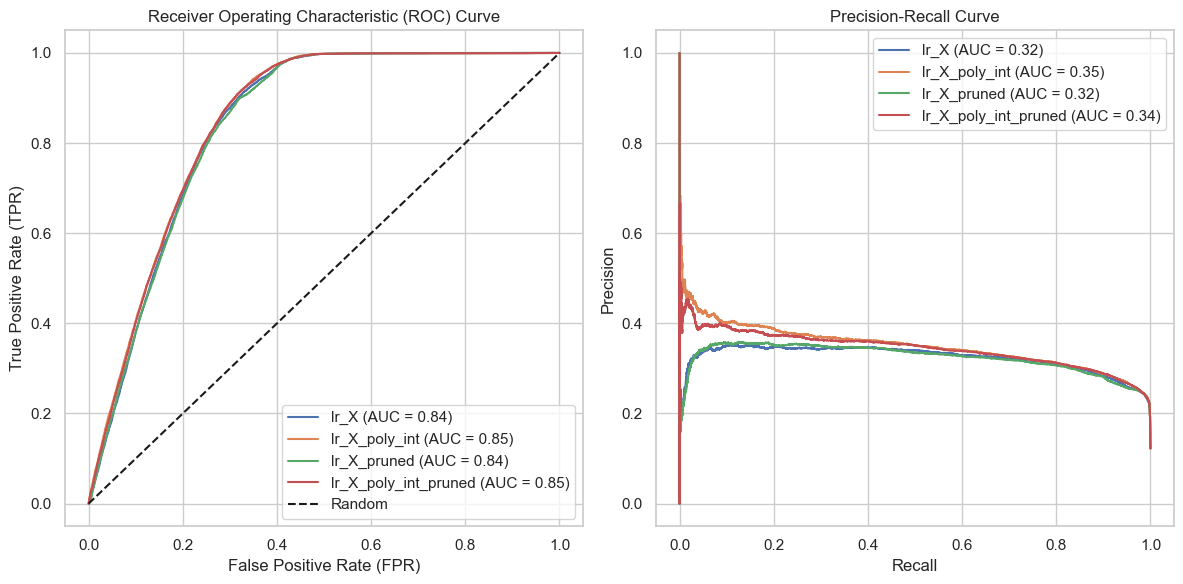

In [437]:
# Calculate ROC curve and AUC for each model
fpr_X, tpr_X, _ = roc_curve(y_test, y_pred_prob[:,1])
roc_auc_X = auc(fpr_X, tpr_X)

fpr_X_poly_int, tpr_X_poly_int, _ = roc_curve(y_test, y_pred_prob_poly_int[:,1])
roc_auc_X_poly_int = auc(fpr_X_poly_int, tpr_X_poly_int)

fpr_X_pruned, tpr_X_pruned, _ = roc_curve(y_test, y_pred_prob_pruned[:,1])
roc_auc_X_pruned = auc(fpr_X_pruned, tpr_X_pruned)

fpr_X_poly_int_pruned, tpr_X_poly_int_pruned, _ = roc_curve(y_test, y_pred_prob_poly_int_pruned[:,1])
roc_auc_X_poly_int_pruned = auc(fpr_X_poly_int_pruned, tpr_X_poly_int_pruned)

# Calculate precision-recall curve and AUC for each model
precision_X, recall_X, _ = precision_recall_curve(y_test, y_pred_prob[:,1])
pr_auc_X = auc(recall_X, precision_X)

precision_X_poly_int, recall_X_poly_int, _ = precision_recall_curve(y_test, y_pred_prob_poly_int[:,1])
pr_auc_X_poly_int = auc(recall_X_poly_int, precision_X_poly_int)

precision_X_pruned, recall_X_pruned, _ = precision_recall_curve(y_test, y_pred_prob_pruned[:,1])
pr_auc_X_pruned = auc(recall_X_pruned, precision_X_pruned)

precision_X_poly_int_pruned, recall_X_poly_int_pruned, _ = precision_recall_curve(y_test, y_pred_prob_poly_int_pruned[:,1])
pr_auc_X_poly_int_pruned = auc(recall_X_poly_int_pruned, precision_X_poly_int_pruned)

# Plotting the ROC and precision-recall curves
plt.figure(figsize=(12, 6))

# ROC curves
plt.subplot(1, 2, 1)
plt.plot(fpr_X, tpr_X, label=f'lr_X (AUC = {roc_auc_X:.2f})')
plt.plot(fpr_X_poly_int, tpr_X_poly_int, label=f'lr_X_poly_int (AUC = {roc_auc_X_poly_int:.2f})')
plt.plot(fpr_X_pruned, tpr_X_pruned, label=f'lr_X_pruned (AUC = {roc_auc_X_pruned:.2f})')
plt.plot(fpr_X_poly_int_pruned, tpr_X_poly_int_pruned, label=f'lr_X_poly_int_pruned (AUC = {roc_auc_X_poly_int_pruned:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Precision-recall curves
plt.subplot(1, 2, 2)
plt.plot(recall_X, precision_X, label=f'lr_X (AUC = {pr_auc_X:.2f})')
plt.plot(recall_X_poly_int, precision_X_poly_int, label=f'lr_X_poly_int (AUC = {pr_auc_X_poly_int:.2f})')
plt.plot(recall_X_pruned, precision_X_pruned, label=f'lr_X_pruned (AUC = {pr_auc_X_pruned:.2f})')
plt.plot(recall_X_poly_int_pruned, precision_X_poly_int_pruned, label=f'lr_X_poly_int_pruned (AUC = {pr_auc_X_poly_int_pruned:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Graphically speaking, the polynomial model seems to be the best among the four, but with very little differences.

## Confusion matrix

The final plot regards the confusion matrix for the four different models

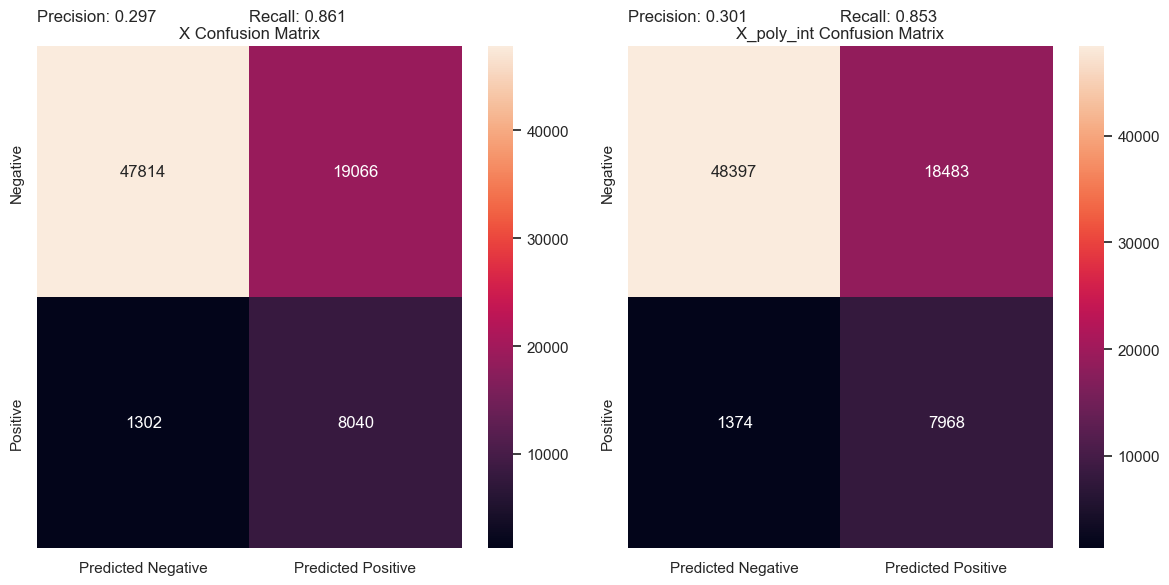

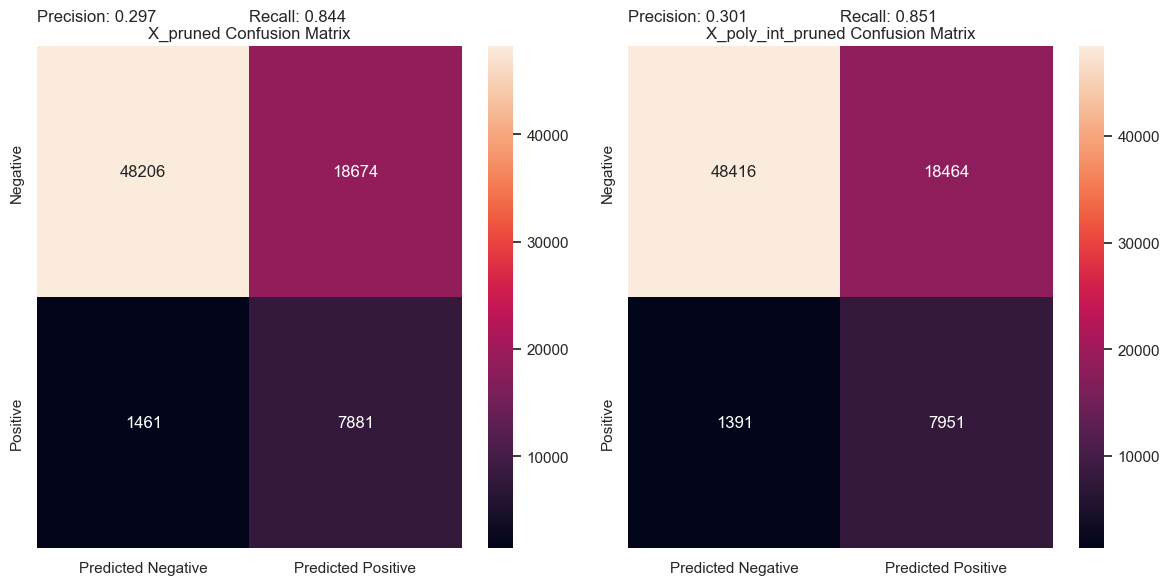

In [455]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plot_cm(ax1[0], y_test, y_pred_X, show_precision_recall=True, title='X Confusion Matrix')
plot_cm(ax1[1], y_test, y_pred_X_poly_int, show_precision_recall=True, title='X_poly_int Confusion Matrix')
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plot_cm(ax2[0], y_test, y_pred_X_pruned, show_precision_recall=True, title='X_pruned Confusion Matrix')
plot_cm(ax2[1], y_test, y_pred_X_poly_int_pruned, show_precision_recall=True,
        title='X_poly_int_pruned Confusion Matrix')
plt.tight_layout()
plt.show()

The final model, considering everything, is chosen to be the lr_X_poly_int, which gave the better 
metrics in predicting the positive respondents, even if it is not so better than the others.

# Conclusion

Very different regularization parameters C, regularization types as Lasso, Elastic Nets, Ridge (the only one shown because of the highly similar results with the other two types, and a little bit better), and different choices of feature to include, looking at metrics like the Mutual Infomration, and keeping in consideration the highly imbalanced nature of the response variable, have brought to a conclusion: the logistic regression is not so good in this case.
Or better, it has a good Recall metric, but a very poor Precision metric, so that it predicts more positive respondents than the real ones (in other words, the real positive out of the total positive predicted is only a small fraction), but the fraction of the predicted negative is small (high recall). So, a good Recall and a poor Precision.
This model hence should be taken with caution, as will predict more positive than the actual ones, but the ones that are predicted positives are likley to be real positive.